In [1]:
import quandl
quandl.ApiConfig.api_key = '1w1X-kbMsxdg4Ts1disD'

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import math
from keras.models import Sequential
from keras.layers import Dense, LSTM, Flatten, Dropout
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [2]:
price_table = quandl.get_table('SHARADAR/SEP', 
                               ticker=['BAC', 'C',
                                       'F', 'GM',
                                       'AAPL', 'MSFT', 
                                       'UAL', 'AAL',
                                       'KO', 'PEP',
                                       'XOM', 'CVX',
                                       'SLB', 'HAL',
                                       'FITB', 'KEY',
                                       'GS', 'JPM'
                                      ]
                               , paginate=True)

In [3]:
sorted_table = price_table.sort_values(by=['ticker','date'], ascending=True).copy()
tickers = sorted(list(set(sorted_table['ticker'])))
price_stock = price_table[price_table['ticker']==tickers[0]][['date','close']].sort_values(by='date', ascending=True)
price_stock.reset_index(inplace=True)

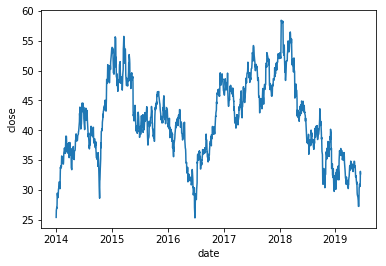

In [4]:
sns.lineplot(x='date', y='close', data=price_stock)

In [5]:
close_df = pd.DataFrame()
close_df['date'] = price_stock['date']
volume_df = pd.DataFrame()
close_df['date'] = price_stock['date']

for ticker in tickers:
    close_df[ticker] = list(sorted_table[sorted_table['ticker']==ticker]['close'])
    volume_ticker = 'v_' + ticker
    volume_df[volume_ticker] = list(sorted_table[sorted_table['ticker']==ticker]['volume'])

no_date_df = close_df[list(close_df.columns)[1:]]
return_df = no_date_df/no_date_df.shift(1) - 1

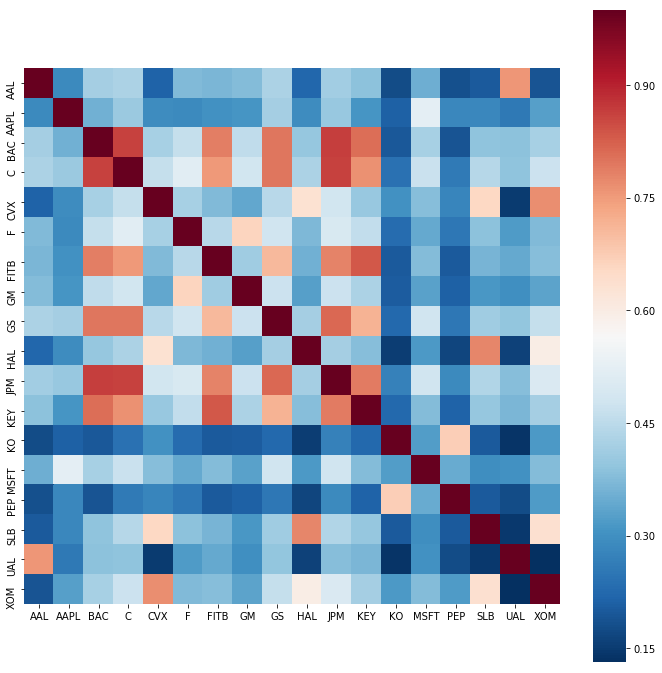

In [6]:
stock_corr = return_df.corr()
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(stock_corr, square=True, cmap="RdBu_r");

In [12]:
# Helper functions used by primary functions below

def slice_data(train_perc, stocks_to_trade, return_df_2):
    train_len = int(return_df.shape[0] * (train_perc))
    volume_to_trade = ['v_'+ticker for ticker in stocks_to_trade]
    for i in volume_to_trade:
        stocks_to_trade.append(i)

    train = return_df_2[stocks_to_trade][1:train_len].copy()
    train['diff'] = train[stocks_to_trade[0]] - train[stocks_to_trade[1]]
    train.reset_index(inplace=True, drop=True)

    test = return_df_2[stocks_to_trade][train_len:].copy()
    test['diff'] = test[stocks_to_trade[0]] - test[stocks_to_trade[1]]
    test.reset_index(inplace=True, drop=True)

    feature_names = volume_to_trade
    feature_names.append('diff')
    
    return train, test, feature_names

def make_variables(dataset, lags, look_back, predict_window):
    features = lags+1
    start = look_back
    stop = len(dataset) - lags - predict_window
    
    lstm_in_X = np.zeros(shape=(stop-start, look_back+1, features))
    lstm_in_Y = np.zeros(shape=(stop-start, look_back+1))

    iter_list = [num for num in range(look_back+1)][::-1]
    for i in range(start, stop):
        for index, j in enumerate(iter_list):
            X = dataset[i-j : i-j+lags+1, -1]
            lstm_in_X[i-start, index] = np.ravel(X)
            Y = dataset[i-j+lags+1, -1]
            lstm_in_Y[i-start, index] = Y
    return lstm_in_X, lstm_in_Y, features

In [13]:
# Create and fit the LSTM network

def train_lstm(train, feature_names, lags, look_back, predict_window, lstm_neurons, dense_layers):
    dataset = np.matrix(train[feature_names])
    lstm_in_X, lstm_in_Y, features = make_variables(dataset, lags, look_back, predict_window)
    train_X = lstm_in_X
    train_Y = lstm_in_Y

    model = Sequential()
    model.add(LSTM(lstm_neurons, input_shape=(look_back+1, features)))
    model.add(Dropout(0.2))
    for neurons in dense_layers:
        model.add(Dense(neurons))
        model.add(Dropout(0.2))
    model.add(Dense(look_back+1))
    model.compile(loss='squared_hinge', optimizer='adam')
    model.fit(train_X, train_Y, epochs=250, batch_size=10, verbose=1)
    
    pred_Y_train = model.predict(train_X)
    predictions = pred_Y_train[:,-1]
    actuals = train_Y[:,-1]
    
    print(model.summary())
    
    return model, dataset, train_X, train_Y, predictions, actuals

In [14]:
# Expanding window test where I fit the model to new data each day

def run_back_test(model_test, dataset, expand_set, feature_names, lags, look_back, predict_window):
    predictions_test = []
    actuals_test = []
    print(expand_set.shape[0] - 1)

    for i in range(0, expand_set.shape[0] - 1):
        print(i)
        curr_row = expand_set[i]
        test_row = expand_set[i+1]
        dataset = np.append(dataset, curr_row, axis=0)
        lstm_in_X, lstm_in_Y, features = make_variables(dataset, lags, look_back, predict_window)
        train_X = lstm_in_X
        train_Y = lstm_in_Y
    
        # Fit the data all the way up to curr_row (today)
        if i%5 == 0:
            model_test.fit(train_X, train_Y, epochs=10, batch_size=10, verbose=1)
    
        # Predict the next day (out of sample) - data for next day is in test_row
        dataset_test = np.append(dataset, test_row, axis=0)
        lstm_in_X_test, lstm_in_Y_test, features = make_variables(dataset_test, lags, look_back, predict_window)
        test_X = lstm_in_X_test
        pred_Y_test = model_test.predict(test_X)
        predict_test = pred_Y_test[-1,-1]
        actual_test = test_row[-1,-1]
        # Store predictions and actuals to for calculating money made and plotting
        predictions_test.append(predict_test)
        actuals_test.append(actual_test)
        
    return predictions_test, actuals_test

In [15]:
def main(tickers, train_perc, lags, look_back, predict_window, lstm_neurons, dense_layers):
    stocks_to_trade = tickers
    return_df_2 = pd.concat([return_df, volume_df], axis=1)
    train, test, feature_names = slice_data(train_perc, stocks_to_trade, return_df_2)
    expand_set = np.matrix(test[feature_names])
    model_train, dataset, train_X, train_Y, predictions_train, actuals_train = train_lstm(train, feature_names, 
                                                                                          lags, look_back, 
                                                                                          predict_window,
                                                                                          lstm_neurons, dense_layers
                                                                                         )
    model_test = model_train
    predictions_test, actuals_test = run_back_test(model_test, dataset, expand_set, feature_names, lags, look_back, predict_window)
    
    return model_test, predictions_test, actuals_test, predictions_train, actuals_train

In [16]:
# Main - for running the pipeline

tickers = ['AAPL','MSFT']
train_perc = 0.40
lags = 20
look_back = 20       # 0 is a look_back of 1, 1 is a look_back of 2, etc.
predict_window = 1

# Neural net parameters
lstm_neurons = 128
dense_layers = [32]

model_AAPL_MSFT, predictions_test_AAPL_MSFT, actuals_test_AAPL_MSFT, predictions_train_AAPL_MSFT, actuals_train_AAPL_MSFT = main(tickers, train_perc, lags, look_back, predict_window, lstm_neurons, dense_layers)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Epoch 1/250
506/506 [==============================] - 2s 3ms/step - loss: 1.0000
Epoch 2/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9996
Epoch 3/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9982
Epoch 4/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9948
Epoch 5/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9961
Epoch 6/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9918
Epoch 7/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9879
Epoch 8/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9819
Epoch 9/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9803
Epoch 10/250
506/506 [=====

506/506 [==============================] - 1s 2ms/step - loss: 0.7641
Epoch 90/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7710
Epoch 91/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7683
Epoch 92/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7577
Epoch 93/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7608
Epoch 94/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7551
Epoch 95/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7538
Epoch 96/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7500
Epoch 97/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7473
Epoch 98/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7540
Epoch 99/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7648
Epoch 100/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7538
Epoch 101/250
50

506/506 [==============================] - 1s 2ms/step - loss: 0.6528
Epoch 187/250
506/506 [==============================] - 1s 2ms/step - loss: 0.6523
Epoch 188/250
506/506 [==============================] - 1s 2ms/step - loss: 0.6568
Epoch 189/250
506/506 [==============================] - 1s 2ms/step - loss: 0.6552
Epoch 190/250
506/506 [==============================] - 1s 2ms/step - loss: 0.6518
Epoch 191/250
506/506 [==============================] - 1s 2ms/step - loss: 0.6596
Epoch 192/250
506/506 [==============================] - 1s 2ms/step - loss: 0.6512
Epoch 193/250
506/506 [==============================] - 1s 2ms/step - loss: 0.6498
Epoch 194/250
506/506 [==============================] - 1s 2ms/step - loss: 0.6497
Epoch 195/250
506/506 [==============================] - 1s 2ms/step - loss: 0.6543
Epoch 196/250
506/506 [==============================] - 1s 2ms/step - loss: 0.6549
Epoch 197/250
506/506 [==============================] - 1s 2ms/step - loss: 0.6493
Epoch 

517/517 [==============================] - 1s 2ms/step - loss: 0.6288
Epoch 3/10
517/517 [==============================] - 1s 2ms/step - loss: 0.6196
Epoch 4/10
517/517 [==============================] - 1s 2ms/step - loss: 0.6203
Epoch 5/10
517/517 [==============================] - 1s 2ms/step - loss: 0.6189
Epoch 6/10
517/517 [==============================] - 1s 2ms/step - loss: 0.6108
Epoch 7/10
517/517 [==============================] - 1s 2ms/step - loss: 0.6190
Epoch 8/10
517/517 [==============================] - 1s 2ms/step - loss: 0.6150
Epoch 9/10
517/517 [==============================] - 1s 2ms/step - loss: 0.6168
Epoch 10/10
517/517 [==============================] - 1s 2ms/step - loss: 0.6149
11
12
13
14
15
Epoch 1/10
522/522 [==============================] - 1s 2ms/step - loss: 0.6249
Epoch 2/10
522/522 [==============================] - 1s 2ms/step - loss: 0.6235
Epoch 3/10
522/522 [==============================] - 1s 2ms/step - loss: 0.6227
Epoch 4/10
522/522 [===

567/567 [==============================] - 1s 2ms/step - loss: 0.6075
Epoch 2/10
567/567 [==============================] - 1s 2ms/step - loss: 0.6032
Epoch 3/10
567/567 [==============================] - 1s 2ms/step - loss: 0.5984
Epoch 4/10
567/567 [==============================] - 1s 2ms/step - loss: 0.6029
Epoch 5/10
567/567 [==============================] - 1s 2ms/step - loss: 0.6002
Epoch 6/10
567/567 [==============================] - 1s 2ms/step - loss: 0.5983
Epoch 7/10
567/567 [==============================] - 1s 2ms/step - loss: 0.6028
Epoch 8/10
567/567 [==============================] - 1s 2ms/step - loss: 0.6021
Epoch 9/10
567/567 [==============================] - 1s 2ms/step - loss: 0.6032
Epoch 10/10
567/567 [==============================] - 1s 2ms/step - loss: 0.5997
61
62
63
64
65
Epoch 1/10
572/572 [==============================] - 1s 2ms/step - loss: 0.6030
Epoch 2/10
572/572 [==============================] - 1s 2ms/step - loss: 0.6063
Epoch 3/10
572/572 [===

612/612 [==============================] - 1s 2ms/step - loss: 0.5686
106
107
108
109
110
Epoch 1/10
617/617 [==============================] - 1s 2ms/step - loss: 0.5746
Epoch 2/10
617/617 [==============================] - 1s 2ms/step - loss: 0.5728
Epoch 3/10
617/617 [==============================] - 1s 2ms/step - loss: 0.5731
Epoch 4/10
617/617 [==============================] - 1s 2ms/step - loss: 0.5718
Epoch 5/10
617/617 [==============================] - 1s 2ms/step - loss: 0.5732
Epoch 6/10
617/617 [==============================] - 1s 2ms/step - loss: 0.5770
Epoch 7/10
617/617 [==============================] - 1s 2ms/step - loss: 0.5711
Epoch 8/10
617/617 [==============================] - 1s 2ms/step - loss: 0.5693
Epoch 9/10
617/617 [==============================] - 1s 2ms/step - loss: 0.5853
Epoch 10/10
617/617 [==============================] - 1s 2ms/step - loss: 0.5774
111
112
113
114
115
Epoch 1/10
622/622 [==============================] - 1s 2ms/step - loss: 0.580

662/662 [==============================] - 1s 2ms/step - loss: 0.5574
Epoch 9/10
662/662 [==============================] - 1s 2ms/step - loss: 0.5572
Epoch 10/10
662/662 [==============================] - 1s 2ms/step - loss: 0.5534
156
157
158
159
160
Epoch 1/10
667/667 [==============================] - 1s 2ms/step - loss: 0.5638
Epoch 2/10
667/667 [==============================] - 1s 2ms/step - loss: 0.5648
Epoch 3/10
667/667 [==============================] - 1s 2ms/step - loss: 0.5636
Epoch 4/10
667/667 [==============================] - 1s 2ms/step - loss: 0.5555
Epoch 5/10
667/667 [==============================] - 1s 2ms/step - loss: 0.5503
Epoch 6/10
667/667 [==============================] - 1s 2ms/step - loss: 0.5539
Epoch 7/10
667/667 [==============================] - 1s 2ms/step - loss: 0.5575
Epoch 8/10
667/667 [==============================] - 1s 2ms/step - loss: 0.5527
Epoch 9/10
667/667 [==============================] - 1s 2ms/step - loss: 0.5493
Epoch 10/10
667/66

712/712 [==============================] - 1s 2ms/step - loss: 0.5531
Epoch 7/10
712/712 [==============================] - 1s 2ms/step - loss: 0.5498
Epoch 8/10
712/712 [==============================] - 1s 2ms/step - loss: 0.5505
Epoch 9/10
712/712 [==============================] - 1s 2ms/step - loss: 0.5469
Epoch 10/10
712/712 [==============================] - 1s 2ms/step - loss: 0.5464
206
207
208
209
210
Epoch 1/10
717/717 [==============================] - 1s 2ms/step - loss: 0.5486
Epoch 2/10
717/717 [==============================] - 1s 2ms/step - loss: 0.5551
Epoch 3/10
717/717 [==============================] - 1s 2ms/step - loss: 0.5411
Epoch 4/10
717/717 [==============================] - 1s 2ms/step - loss: 0.5469
Epoch 5/10
717/717 [==============================] - 1s 2ms/step - loss: 0.5429
Epoch 6/10
717/717 [==============================] - 1s 2ms/step - loss: 0.5570
Epoch 7/10
717/717 [==============================] - 1s 2ms/step - loss: 0.5459
Epoch 8/10
717/717

762/762 [==============================] - 1s 2ms/step - loss: 0.5363
Epoch 5/10
762/762 [==============================] - 1s 2ms/step - loss: 0.5272
Epoch 6/10
762/762 [==============================] - 1s 2ms/step - loss: 0.5274
Epoch 7/10
762/762 [==============================] - 1s 2ms/step - loss: 0.5313
Epoch 8/10
762/762 [==============================] - 1s 2ms/step - loss: 0.5311
Epoch 9/10
762/762 [==============================] - 1s 2ms/step - loss: 0.5256
Epoch 10/10
762/762 [==============================] - 1s 2ms/step - loss: 0.5267
256
257
258
259
260
Epoch 1/10
767/767 [==============================] - 1s 2ms/step - loss: 0.5394
Epoch 2/10
767/767 [==============================] - 1s 2ms/step - loss: 0.5324
Epoch 3/10
767/767 [==============================] - 1s 2ms/step - loss: 0.5347
Epoch 4/10
767/767 [==============================] - 1s 2ms/step - loss: 0.5309
Epoch 5/10
767/767 [==============================] - 2s 2ms/step - loss: 0.5283
Epoch 6/10
767/767

812/812 [==============================] - 2s 2ms/step - loss: 0.4967
Epoch 3/10
812/812 [==============================] - 2s 2ms/step - loss: 0.5025
Epoch 4/10
812/812 [==============================] - 1s 2ms/step - loss: 0.4986
Epoch 5/10
812/812 [==============================] - 1s 2ms/step - loss: 0.4987
Epoch 6/10
812/812 [==============================] - 1s 2ms/step - loss: 0.4966
Epoch 7/10
812/812 [==============================] - 1s 2ms/step - loss: 0.4915
Epoch 8/10
812/812 [==============================] - 2s 2ms/step - loss: 0.4971
Epoch 9/10
812/812 [==============================] - 2s 2ms/step - loss: 0.4916
Epoch 10/10
812/812 [==============================] - 2s 2ms/step - loss: 0.4962
306
307
308
309
310
Epoch 1/10
817/817 [==============================] - 2s 2ms/step - loss: 0.4950
Epoch 2/10
817/817 [==============================] - 2s 2ms/step - loss: 0.4977
Epoch 3/10
817/817 [==============================] - 2s 2ms/step - loss: 0.4935
Epoch 4/10
817/817

857/857 [==============================] - 2s 2ms/step - loss: 0.4548
351
352
353
354
355
Epoch 1/10
862/862 [==============================] - 1s 2ms/step - loss: 0.4836
Epoch 2/10
862/862 [==============================] - 2s 2ms/step - loss: 0.4930
Epoch 3/10
862/862 [==============================] - 2s 2ms/step - loss: 0.4599
Epoch 4/10
862/862 [==============================] - 2s 2ms/step - loss: 0.4544
Epoch 5/10
862/862 [==============================] - 2s 2ms/step - loss: 0.4471
Epoch 6/10
862/862 [==============================] - 1s 2ms/step - loss: 0.4577
Epoch 7/10
862/862 [==============================] - 2s 2ms/step - loss: 0.4588
Epoch 8/10
862/862 [==============================] - 2s 2ms/step - loss: 0.4480
Epoch 9/10
862/862 [==============================] - 2s 2ms/step - loss: 0.4548
Epoch 10/10
862/862 [==============================] - 2s 2ms/step - loss: 0.4539
356
357
358
359
360
Epoch 1/10
867/867 [==============================] - 2s 2ms/step - loss: 0.465

907/907 [==============================] - 2s 2ms/step - loss: 0.4366
Epoch 9/10
907/907 [==============================] - 2s 2ms/step - loss: 0.4319
Epoch 10/10
907/907 [==============================] - 2s 2ms/step - loss: 0.4225
401
402
403
404
405
Epoch 1/10
912/912 [==============================] - 2s 2ms/step - loss: 0.4267
Epoch 2/10
912/912 [==============================] - 2s 2ms/step - loss: 0.4276
Epoch 3/10
912/912 [==============================] - 2s 2ms/step - loss: 0.4229
Epoch 4/10
912/912 [==============================] - 2s 2ms/step - loss: 0.4237
Epoch 5/10
912/912 [==============================] - 2s 2ms/step - loss: 0.4196
Epoch 6/10
912/912 [==============================] - 2s 2ms/step - loss: 0.4189
Epoch 7/10
912/912 [==============================] - 2s 2ms/step - loss: 0.4191
Epoch 8/10
912/912 [==============================] - 2s 2ms/step - loss: 0.4135
Epoch 9/10
912/912 [==============================] - 2s 2ms/step - loss: 0.4165
Epoch 10/10
912/91

957/957 [==============================] - 2s 2ms/step - loss: 0.4147
Epoch 7/10
957/957 [==============================] - 2s 2ms/step - loss: 0.4061
Epoch 8/10
957/957 [==============================] - 2s 2ms/step - loss: 0.3949
Epoch 9/10
957/957 [==============================] - 2s 2ms/step - loss: 0.3955
Epoch 10/10
957/957 [==============================] - 2s 2ms/step - loss: 0.4035
451
452
453
454
455
Epoch 1/10
962/962 [==============================] - 2s 2ms/step - loss: 0.4339
Epoch 2/10
962/962 [==============================] - 2s 2ms/step - loss: 0.4611
Epoch 3/10
962/962 [==============================] - 2s 2ms/step - loss: 0.4111
Epoch 4/10
962/962 [==============================] - 2s 2ms/step - loss: 0.3944
Epoch 5/10
962/962 [==============================] - 2s 2ms/step - loss: 0.3947
Epoch 6/10
962/962 [==============================] - 2s 2ms/step - loss: 0.3923
Epoch 7/10
962/962 [==============================] - 2s 2ms/step - loss: 0.3925
Epoch 8/10
962/962

1007/1007 [==============================] - 2s 2ms/step - loss: 0.3809
Epoch 5/10
1007/1007 [==============================] - 2s 2ms/step - loss: 0.3917
Epoch 6/10
1007/1007 [==============================] - 2s 2ms/step - loss: 0.3768
Epoch 7/10
1007/1007 [==============================] - 2s 2ms/step - loss: 0.3849
Epoch 8/10
1007/1007 [==============================] - 2s 2ms/step - loss: 0.3871
Epoch 9/10
1007/1007 [==============================] - 2s 2ms/step - loss: 0.4030
Epoch 10/10
1007/1007 [==============================] - 2s 2ms/step - loss: 0.4284
501
502
503
504
505
Epoch 1/10
1012/1012 [==============================] - 2s 2ms/step - loss: 0.4260
Epoch 2/10
1012/1012 [==============================] - 2s 2ms/step - loss: 0.4161
Epoch 3/10
1012/1012 [==============================] - 2s 2ms/step - loss: 0.4028
Epoch 4/10
1012/1012 [==============================] - 2s 2ms/step - loss: 0.3821
Epoch 5/10
1012/1012 [==============================] - 2s 2ms/step - loss: 0

1052/1052 [==============================] - 2s 2ms/step - loss: 0.3644
546
547
548
549
550
Epoch 1/10
1057/1057 [==============================] - 2s 2ms/step - loss: 0.3809
Epoch 2/10
1057/1057 [==============================] - 2s 2ms/step - loss: 0.3692A: 0s - loss
Epoch 3/10
1057/1057 [==============================] - 2s 2ms/step - loss: 0.3689
Epoch 4/10
1057/1057 [==============================] - 2s 2ms/step - loss: 0.3704
Epoch 5/10
1057/1057 [==============================] - 2s 2ms/step - loss: 0.4203
Epoch 6/10
1057/1057 [==============================] - 2s 2ms/step - loss: 0.3859
Epoch 7/10
1057/1057 [==============================] - 2s 2ms/step - loss: 0.3718
Epoch 8/10
1057/1057 [==============================] - 2s 2ms/step - loss: 0.3719
Epoch 9/10
1057/1057 [==============================] - 2s 2ms/step - loss: 0.3519
Epoch 10/10
1057/1057 [==============================] - 2s 2ms/step - loss: 0.3511
551
552
553
554
555
Epoch 1/10
1062/1062 [=======================

1102/1102 [==============================] - 2s 2ms/step - loss: 0.3571
Epoch 7/10
1102/1102 [==============================] - 2s 2ms/step - loss: 0.3776
Epoch 8/10
1102/1102 [==============================] - 2s 2ms/step - loss: 0.3573
Epoch 9/10
1102/1102 [==============================] - 2s 2ms/step - loss: 0.3703
Epoch 10/10
1102/1102 [==============================] - 2s 2ms/step - loss: 0.3606
596
597
598
599
600
Epoch 1/10
1107/1107 [==============================] - 2s 2ms/step - loss: 0.3707
Epoch 2/10
1107/1107 [==============================] - 2s 2ms/step - loss: 0.3603
Epoch 3/10
1107/1107 [==============================] - 2s 2ms/step - loss: 0.3498
Epoch 4/10
1107/1107 [==============================] - 2s 2ms/step - loss: 0.3428
Epoch 5/10
1107/1107 [==============================] - 2s 2ms/step - loss: 0.3505
Epoch 6/10
1107/1107 [==============================] - 2s 2ms/step - loss: 0.3491
Epoch 7/10
1107/1107 [==============================] - 2s 2ms/step - loss: 0

1152/1152 [==============================] - 2s 2ms/step - loss: 0.3443
Epoch 3/10
1152/1152 [==============================] - 2s 2ms/step - loss: 0.3398
Epoch 4/10
1152/1152 [==============================] - 2s 2ms/step - loss: 0.3380
Epoch 5/10
1152/1152 [==============================] - 2s 2ms/step - loss: 0.3607
Epoch 6/10
1152/1152 [==============================] - 2s 2ms/step - loss: 0.4014
Epoch 7/10
1152/1152 [==============================] - 2s 2ms/step - loss: 0.7448
Epoch 8/10
1152/1152 [==============================] - 2s 2ms/step - loss: 0.4830
Epoch 9/10
1152/1152 [==============================] - 2s 2ms/step - loss: 0.4099
Epoch 10/10
1152/1152 [==============================] - 2s 2ms/step - loss: 0.3803
646
647
648
649
650
Epoch 1/10
1157/1157 [==============================] - 2s 2ms/step - loss: 0.3896
Epoch 2/10
1157/1157 [==============================] - 2s 2ms/step - loss: 0.4058
Epoch 3/10
1157/1157 [==============================] - 2s 2ms/step - loss: 0

1197/1197 [==============================] - 2s 2ms/step - loss: 0.3287
Epoch 9/10
1197/1197 [==============================] - 2s 2ms/step - loss: 0.3235
Epoch 10/10
1197/1197 [==============================] - 2s 2ms/step - loss: 0.3170
691
692
693
694
695
Epoch 1/10
1202/1202 [==============================] - 2s 2ms/step - loss: 0.3544
Epoch 2/10
1202/1202 [==============================] - 2s 2ms/step - loss: 0.3332
Epoch 3/10
1202/1202 [==============================] - 2s 2ms/step - loss: 0.3388
Epoch 4/10
1202/1202 [==============================] - 2s 2ms/step - loss: 0.3282
Epoch 5/10
1202/1202 [==============================] - 2s 2ms/step - loss: 0.3282
Epoch 6/10
1202/1202 [==============================] - 2s 2ms/step - loss: 0.3428
Epoch 7/10
1202/1202 [==============================] - 2s 2ms/step - loss: 0.3459
Epoch 8/10
1202/1202 [==============================] - 2s 2ms/step - loss: 0.3568
Epoch 9/10
1202/1202 [==============================] - 2s 2ms/step - loss: 0

1247/1247 [==============================] - 2s 2ms/step - loss: 0.3243
Epoch 5/10
1247/1247 [==============================] - 2s 2ms/step - loss: 0.3280
Epoch 6/10
1247/1247 [==============================] - 2s 2ms/step - loss: 0.3222
Epoch 7/10
1247/1247 [==============================] - 2s 2ms/step - loss: 0.3250
Epoch 8/10
1247/1247 [==============================] - 3s 2ms/step - loss: 0.3672
Epoch 9/10
1247/1247 [==============================] - 2s 2ms/step - loss: 0.3508
Epoch 10/10
1247/1247 [==============================] - 2s 2ms/step - loss: 0.3400
741
742
743
744
745
Epoch 1/10
1252/1252 [==============================] - 2s 2ms/step - loss: 0.3630
Epoch 2/10
1252/1252 [==============================] - 3s 2ms/step - loss: 0.3844
Epoch 3/10
1252/1252 [==============================] - 2s 2ms/step - loss: 0.3784
Epoch 4/10
1252/1252 [==============================] - 2s 2ms/step - loss: 0.3616
Epoch 5/10
1252/1252 [==============================] - 2s 2ms/step - loss: 0

1292/1292 [==============================] - 2s 2ms/step - loss: 0.3178
786
787
788
789
790
Epoch 1/10
1297/1297 [==============================] - 2s 2ms/step - loss: 0.3281
Epoch 2/10
1297/1297 [==============================] - 2s 2ms/step - loss: 0.3104
Epoch 3/10
1297/1297 [==============================] - 2s 2ms/step - loss: 0.3154
Epoch 4/10
1297/1297 [==============================] - 2s 2ms/step - loss: 0.3079
Epoch 5/10
1297/1297 [==============================] - 2s 2ms/step - loss: 0.3092
Epoch 6/10
1297/1297 [==============================] - 2s 2ms/step - loss: 0.3062
Epoch 7/10
1297/1297 [==============================] - 2s 2ms/step - loss: 0.3053
Epoch 8/10
1297/1297 [==============================] - 2s 2ms/step - loss: 0.3224
Epoch 9/10
1297/1297 [==============================] - 2s 2ms/step - loss: 0.3169
Epoch 10/10
1297/1297 [==============================] - 2s 2ms/step - loss: 0.3043
791
792
793
794
795
Epoch 1/10
1302/1302 [==============================] - 2

In [17]:
# Main - for running the pipeline

tickers = ['GS','JPM']
train_perc = 0.40
lags = 20
look_back = 20       # 0 is a look_back of 1, 1 is a look_back of 2, etc.
predict_window = 1

# Neural net parameters
lstm_neurons = 128
dense_layers = [32]

model_GS_JPM, predictions_test_GS_JPM, actuals_test_GS_JPM, predictions_train_GS_JPM, actuals_train_GS_JPM = main(tickers, train_perc, lags, look_back, predict_window, lstm_neurons, dense_layers)

Epoch 1/250
506/506 [==============================] - 2s 3ms/step - loss: 1.0000
Epoch 2/250
506/506 [==============================] - 1s 2ms/step - loss: 1.0000
Epoch 3/250
506/506 [==============================] - 1s 2ms/step - loss: 1.0000
Epoch 4/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9999
Epoch 5/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9999
Epoch 6/250
506/506 [==============================] - 1s 2ms/step - loss: 1.0000
Epoch 7/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9999
Epoch 8/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9997
Epoch 9/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9997
Epoch 10/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9998
Epoch 11/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9997
Epoch 12/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9999
Epoch 13/250


506/506 [==============================] - 1s 2ms/step - loss: 0.8364
Epoch 100/250
506/506 [==============================] - 1s 2ms/step - loss: 0.8321
Epoch 101/250
506/506 [==============================] - 1s 2ms/step - loss: 0.8317
Epoch 102/250
506/506 [==============================] - 1s 2ms/step - loss: 0.8327
Epoch 103/250
506/506 [==============================] - 1s 2ms/step - loss: 0.8372
Epoch 104/250
506/506 [==============================] - 1s 2ms/step - loss: 0.8306
Epoch 105/250
506/506 [==============================] - 1s 2ms/step - loss: 0.8288
Epoch 106/250
506/506 [==============================] - 1s 2ms/step - loss: 0.8284
Epoch 107/250
506/506 [==============================] - 1s 2ms/step - loss: 0.8298
Epoch 108/250
506/506 [==============================] - 1s 2ms/step - loss: 0.8261
Epoch 109/250
506/506 [==============================] - 1s 2ms/step - loss: 0.8241
Epoch 110/250
506/506 [==============================] - 1s 2ms/step - loss: 0.8253
Epoch 

506/506 [==============================] - 1s 3ms/step - loss: 0.7338
Epoch 197/250
506/506 [==============================] - 1s 3ms/step - loss: 0.7293
Epoch 198/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7276
Epoch 199/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7252
Epoch 200/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7315
Epoch 201/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7250
Epoch 202/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7232
Epoch 203/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7250
Epoch 204/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7229
Epoch 205/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7250
Epoch 206/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7185
Epoch 207/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7218
Epoch 

522/522 [==============================] - 1s 2ms/step - loss: 0.6875
Epoch 3/10
522/522 [==============================] - 1s 2ms/step - loss: 0.6826
Epoch 4/10
522/522 [==============================] - 1s 2ms/step - loss: 0.6847
Epoch 5/10
522/522 [==============================] - 1s 2ms/step - loss: 0.6842
Epoch 6/10
522/522 [==============================] - 1s 2ms/step - loss: 0.6885
Epoch 7/10
522/522 [==============================] - 1s 2ms/step - loss: 0.6821
Epoch 8/10
522/522 [==============================] - 1s 2ms/step - loss: 0.6843
Epoch 9/10
522/522 [==============================] - 1s 2ms/step - loss: 0.6797
Epoch 10/10
522/522 [==============================] - 1s 2ms/step - loss: 0.6783
16
17
18
19
20
Epoch 1/10
527/527 [==============================] - 1s 2ms/step - loss: 0.6829
Epoch 2/10
527/527 [==============================] - 1s 2ms/step - loss: 0.6795
Epoch 3/10
527/527 [==============================] - 1s 2ms/step - loss: 0.6769
Epoch 4/10
527/527 [===

572/572 [==============================] - 1s 2ms/step - loss: 0.6493
Epoch 2/10
572/572 [==============================] - 1s 2ms/step - loss: 0.6553
Epoch 3/10
572/572 [==============================] - 1s 2ms/step - loss: 0.6446
Epoch 4/10
572/572 [==============================] - 1s 2ms/step - loss: 0.6467
Epoch 5/10
572/572 [==============================] - 1s 2ms/step - loss: 0.6538
Epoch 6/10
572/572 [==============================] - 1s 2ms/step - loss: 0.6454
Epoch 7/10
572/572 [==============================] - 1s 2ms/step - loss: 0.6450
Epoch 8/10
572/572 [==============================] - 1s 2ms/step - loss: 0.6419
Epoch 9/10
572/572 [==============================] - 1s 2ms/step - loss: 0.6437
Epoch 10/10
572/572 [==============================] - 1s 2ms/step - loss: 0.6440
66
67
68
69
70
Epoch 1/10
577/577 [==============================] - 1s 2ms/step - loss: 0.6438
Epoch 2/10
577/577 [==============================] - 1s 2ms/step - loss: 0.6425
Epoch 3/10
577/577 [===

617/617 [==============================] - 1s 2ms/step - loss: 0.6153
111
112
113
114
115
Epoch 1/10
622/622 [==============================] - 1s 2ms/step - loss: 0.6135
Epoch 2/10
622/622 [==============================] - 1s 2ms/step - loss: 0.6184
Epoch 3/10
622/622 [==============================] - 1s 2ms/step - loss: 0.6120
Epoch 4/10
622/622 [==============================] - 1s 2ms/step - loss: 0.6145
Epoch 5/10
622/622 [==============================] - 1s 2ms/step - loss: 0.6122
Epoch 6/10
622/622 [==============================] - 1s 2ms/step - loss: 0.6099
Epoch 7/10
622/622 [==============================] - 1s 2ms/step - loss: 0.6138
Epoch 8/10
622/622 [==============================] - 1s 2ms/step - loss: 0.6140
Epoch 9/10
622/622 [==============================] - 1s 2ms/step - loss: 0.6097
Epoch 10/10
622/622 [==============================] - 1s 2ms/step - loss: 0.6106
116
117
118
119
120
Epoch 1/10
627/627 [==============================] - 1s 2ms/step - loss: 0.611

667/667 [==============================] - 1s 2ms/step - loss: 0.5973
Epoch 9/10
667/667 [==============================] - 1s 2ms/step - loss: 0.5957
Epoch 10/10
667/667 [==============================] - 1s 2ms/step - loss: 0.5982
161
162
163
164
165
Epoch 1/10
672/672 [==============================] - 1s 2ms/step - loss: 0.5969
Epoch 2/10
672/672 [==============================] - 1s 2ms/step - loss: 0.6032
Epoch 3/10
672/672 [==============================] - 1s 2ms/step - loss: 0.5974
Epoch 4/10
672/672 [==============================] - 1s 2ms/step - loss: 0.5961
Epoch 5/10
672/672 [==============================] - 1s 2ms/step - loss: 0.5962
Epoch 6/10
672/672 [==============================] - 1s 2ms/step - loss: 0.6014
Epoch 7/10
672/672 [==============================] - 1s 2ms/step - loss: 0.6081
Epoch 8/10
672/672 [==============================] - 1s 2ms/step - loss: 0.5992
Epoch 9/10
672/672 [==============================] - 1s 2ms/step - loss: 0.5917
Epoch 10/10
672/67

717/717 [==============================] - 1s 2ms/step - loss: 0.5829
Epoch 7/10
717/717 [==============================] - 1s 2ms/step - loss: 0.5818
Epoch 8/10
717/717 [==============================] - 1s 2ms/step - loss: 0.5812
Epoch 9/10
717/717 [==============================] - 1s 2ms/step - loss: 0.5879
Epoch 10/10
717/717 [==============================] - 1s 2ms/step - loss: 0.5874
211
212
213
214
215
Epoch 1/10
722/722 [==============================] - 1s 2ms/step - loss: 0.5954
Epoch 2/10
722/722 [==============================] - 1s 2ms/step - loss: 0.5935
Epoch 3/10
722/722 [==============================] - 1s 2ms/step - loss: 0.5830
Epoch 4/10
722/722 [==============================] - 1s 2ms/step - loss: 0.5896
Epoch 5/10
722/722 [==============================] - 1s 2ms/step - loss: 0.5915
Epoch 6/10
722/722 [==============================] - 1s 2ms/step - loss: 0.5866
Epoch 7/10
722/722 [==============================] - 1s 2ms/step - loss: 0.5853
Epoch 8/10
722/722

767/767 [==============================] - 1s 2ms/step - loss: 0.5687
Epoch 5/10
767/767 [==============================] - 1s 2ms/step - loss: 0.5608
Epoch 6/10
767/767 [==============================] - 1s 2ms/step - loss: 0.5595
Epoch 7/10
767/767 [==============================] - 1s 2ms/step - loss: 0.5593
Epoch 8/10
767/767 [==============================] - 1s 2ms/step - loss: 0.5605
Epoch 9/10
767/767 [==============================] - 1s 2ms/step - loss: 0.5585
Epoch 10/10
767/767 [==============================] - 1s 2ms/step - loss: 0.5548
261
262
263
264
265
Epoch 1/10
772/772 [==============================] - 1s 2ms/step - loss: 0.5622
Epoch 2/10
772/772 [==============================] - 1s 2ms/step - loss: 0.5587
Epoch 3/10
772/772 [==============================] - 1s 2ms/step - loss: 0.5687
Epoch 4/10
772/772 [==============================] - 1s 2ms/step - loss: 0.5704
Epoch 5/10
772/772 [==============================] - 1s 2ms/step - loss: 0.5606
Epoch 6/10
772/772

817/817 [==============================] - 1s 2ms/step - loss: 0.5280
Epoch 3/10
817/817 [==============================] - 1s 2ms/step - loss: 0.5281
Epoch 4/10
817/817 [==============================] - 2s 2ms/step - loss: 0.5170
Epoch 5/10
817/817 [==============================] - 2s 2ms/step - loss: 0.5264
Epoch 6/10
817/817 [==============================] - 2s 2ms/step - loss: 0.5335
Epoch 7/10
817/817 [==============================] - 1s 2ms/step - loss: 0.5259
Epoch 8/10
817/817 [==============================] - 2s 2ms/step - loss: 0.5241
Epoch 9/10
817/817 [==============================] - 2s 2ms/step - loss: 0.5277
Epoch 10/10
817/817 [==============================] - 2s 2ms/step - loss: 0.5169
311
312
313
314
315
Epoch 1/10
822/822 [==============================] - 2s 2ms/step - loss: 0.5333
Epoch 2/10
822/822 [==============================] - 2s 2ms/step - loss: 0.5649
Epoch 3/10
822/822 [==============================] - 2s 2ms/step - loss: 0.5445
Epoch 4/10
822/822

862/862 [==============================] - 2s 2ms/step - loss: 0.4868
356
357
358
359
360
Epoch 1/10
867/867 [==============================] - 2s 2ms/step - loss: 0.4914
Epoch 2/10
867/867 [==============================] - 2s 2ms/step - loss: 0.4897
Epoch 3/10
867/867 [==============================] - 2s 2ms/step - loss: 0.4852
Epoch 4/10
867/867 [==============================] - 2s 2ms/step - loss: 0.4805
Epoch 5/10
867/867 [==============================] - 2s 2ms/step - loss: 0.4824
Epoch 6/10
867/867 [==============================] - 2s 2ms/step - loss: 0.4804
Epoch 7/10
867/867 [==============================] - 2s 2ms/step - loss: 0.4809
Epoch 8/10
867/867 [==============================] - 2s 2ms/step - loss: 0.4768
Epoch 9/10
867/867 [==============================] - 2s 2ms/step - loss: 0.4792
Epoch 10/10
867/867 [==============================] - 2s 2ms/step - loss: 0.4796
361
362
363
364
365
Epoch 1/10
872/872 [==============================] - 2s 2ms/step - loss: 0.477

912/912 [==============================] - 2s 2ms/step - loss: 0.4483
Epoch 9/10
912/912 [==============================] - 2s 2ms/step - loss: 0.4447
Epoch 10/10
912/912 [==============================] - 2s 2ms/step - loss: 0.4460
406
407
408
409
410
Epoch 1/10
917/917 [==============================] - 2s 2ms/step - loss: 0.4705
Epoch 2/10
917/917 [==============================] - 2s 2ms/step - loss: 0.4582
Epoch 3/10
917/917 [==============================] - 2s 2ms/step - loss: 0.4564
Epoch 4/10
917/917 [==============================] - 2s 2ms/step - loss: 0.4497
Epoch 5/10
917/917 [==============================] - 2s 2ms/step - loss: 0.4480
Epoch 6/10
917/917 [==============================] - 2s 2ms/step - loss: 0.4462
Epoch 7/10
917/917 [==============================] - 2s 2ms/step - loss: 0.4393
Epoch 8/10
917/917 [==============================] - 2s 2ms/step - loss: 0.4407
Epoch 9/10
917/917 [==============================] - 2s 2ms/step - loss: 0.4392
Epoch 10/10
917/91

962/962 [==============================] - 2s 2ms/step - loss: 0.4182
Epoch 7/10
962/962 [==============================] - 2s 2ms/step - loss: 0.4162
Epoch 8/10
962/962 [==============================] - 2s 2ms/step - loss: 0.4185
Epoch 9/10
962/962 [==============================] - 2s 2ms/step - loss: 0.4396
Epoch 10/10
962/962 [==============================] - 2s 2ms/step - loss: 0.4287
456
457
458
459
460
Epoch 1/10
967/967 [==============================] - 2s 2ms/step - loss: 0.4333
Epoch 2/10
967/967 [==============================] - 2s 2ms/step - loss: 0.4263
Epoch 3/10
967/967 [==============================] - 2s 2ms/step - loss: 0.4286
Epoch 4/10
967/967 [==============================] - 2s 2ms/step - loss: 0.4261
Epoch 5/10
967/967 [==============================] - 2s 2ms/step - loss: 0.4213
Epoch 6/10
967/967 [==============================] - 2s 2ms/step - loss: 0.4212
Epoch 7/10
967/967 [==============================] - 2s 2ms/step - loss: 0.4141
Epoch 8/10
967/967

1012/1012 [==============================] - 2s 2ms/step - loss: 0.4034
Epoch 5/10
1012/1012 [==============================] - 2s 2ms/step - loss: 0.3997
Epoch 6/10
1012/1012 [==============================] - 2s 2ms/step - loss: 0.4083
Epoch 7/10
1012/1012 [==============================] - 2s 2ms/step - loss: 0.3976
Epoch 8/10
1012/1012 [==============================] - 2s 2ms/step - loss: 0.4093
Epoch 9/10
1012/1012 [==============================] - 2s 2ms/step - loss: 0.4010
Epoch 10/10
1012/1012 [==============================] - 2s 2ms/step - loss: 0.3959
506
507
508
509
510
Epoch 1/10
1017/1017 [==============================] - 2s 2ms/step - loss: 0.3910
Epoch 2/10
1017/1017 [==============================] - 2s 2ms/step - loss: 0.3913
Epoch 3/10
1017/1017 [==============================] - 2s 2ms/step - loss: 0.3880
Epoch 4/10
1017/1017 [==============================] - 2s 2ms/step - loss: 0.3888
Epoch 5/10
1017/1017 [==============================] - 2s 2ms/step - loss: 0

1057/1057 [==============================] - 2s 2ms/step - loss: 0.3723
551
552
553
554
555
Epoch 1/10
1062/1062 [==============================] - 2s 2ms/step - loss: 0.3840
Epoch 2/10
1062/1062 [==============================] - 2s 2ms/step - loss: 0.3772
Epoch 3/10
1062/1062 [==============================] - 2s 2ms/step - loss: 0.3759
Epoch 4/10
1062/1062 [==============================] - 2s 2ms/step - loss: 0.3727
Epoch 5/10
1062/1062 [==============================] - 2s 2ms/step - loss: 0.3643
Epoch 6/10
1062/1062 [==============================] - 2s 2ms/step - loss: 0.3744
Epoch 7/10
1062/1062 [==============================] - 2s 2ms/step - loss: 0.3748
Epoch 8/10
1062/1062 [==============================] - 2s 2ms/step - loss: 0.3771
Epoch 9/10
1062/1062 [==============================] - 2s 2ms/step - loss: 0.3988
Epoch 10/10
1062/1062 [==============================] - 2s 2ms/step - loss: 0.3996
556
557
558
559
560
Epoch 1/10
1067/1067 [==============================] - 2

1107/1107 [==============================] - 2s 2ms/step - loss: 0.3427
Epoch 7/10
1107/1107 [==============================] - 2s 2ms/step - loss: 0.3578
Epoch 8/10
1107/1107 [==============================] - 2s 2ms/step - loss: 0.3553
Epoch 9/10
1107/1107 [==============================] - 2s 2ms/step - loss: 0.3536
Epoch 10/10
1107/1107 [==============================] - 2s 2ms/step - loss: 0.3522
601
602
603
604
605
Epoch 1/10
1112/1112 [==============================] - 2s 2ms/step - loss: 0.3788
Epoch 2/10
1112/1112 [==============================] - 2s 2ms/step - loss: 0.3645
Epoch 3/10
1112/1112 [==============================] - 2s 2ms/step - loss: 0.3518
Epoch 4/10
1112/1112 [==============================] - 2s 2ms/step - loss: 0.3576
Epoch 5/10
1112/1112 [==============================] - 2s 2ms/step - loss: 0.3618
Epoch 6/10
1112/1112 [==============================] - 2s 2ms/step - loss: 0.3662
Epoch 7/10
1112/1112 [==============================] - 2s 2ms/step - loss: 0

1157/1157 [==============================] - 2s 2ms/step - loss: 0.3364
Epoch 3/10
1157/1157 [==============================] - 2s 2ms/step - loss: 0.3357
Epoch 4/10
1157/1157 [==============================] - 2s 2ms/step - loss: 0.3276
Epoch 5/10
1157/1157 [==============================] - 2s 2ms/step - loss: 0.3345
Epoch 6/10
1157/1157 [==============================] - 3s 2ms/step - loss: 0.3397
Epoch 7/10
1157/1157 [==============================] - 2s 2ms/step - loss: 0.3433
Epoch 8/10
1157/1157 [==============================] - 2s 2ms/step - loss: 0.3339
Epoch 9/10
1157/1157 [==============================] - 2s 2ms/step - loss: 0.3319
Epoch 10/10
1157/1157 [==============================] - 2s 2ms/step - loss: 0.3320
651
652
653
654
655
Epoch 1/10
1162/1162 [==============================] - 2s 2ms/step - loss: 0.3450
Epoch 2/10
1162/1162 [==============================] - 2s 2ms/step - loss: 0.3446
Epoch 3/10
1162/1162 [==============================] - 2s 2ms/step - loss: 0

1202/1202 [==============================] - 2s 2ms/step - loss: 0.3271
Epoch 9/10
1202/1202 [==============================] - 2s 2ms/step - loss: 0.3233
Epoch 10/10
1202/1202 [==============================] - 2s 2ms/step - loss: 0.3252
696
697
698
699
700
Epoch 1/10
1207/1207 [==============================] - 2s 2ms/step - loss: 0.3862
Epoch 2/10
1207/1207 [==============================] - 2s 2ms/step - loss: 0.7759
Epoch 3/10
1207/1207 [==============================] - 2s 2ms/step - loss: 0.8743
Epoch 4/10
1207/1207 [==============================] - 2s 2ms/step - loss: 0.6958
Epoch 5/10
1207/1207 [==============================] - 2s 2ms/step - loss: 0.6102
Epoch 6/10
1207/1207 [==============================] - 2s 2ms/step - loss: 0.5413
Epoch 7/10
1207/1207 [==============================] - 2s 2ms/step - loss: 0.5197
Epoch 8/10
1207/1207 [==============================] - 2s 2ms/step - loss: 0.4863
Epoch 9/10
1207/1207 [==============================] - 2s 2ms/step - loss: 0

1252/1252 [==============================] - 3s 3ms/step - loss: 0.3224
Epoch 5/10
1252/1252 [==============================] - 3s 2ms/step - loss: 0.3387
Epoch 6/10
1252/1252 [==============================] - 3s 2ms/step - loss: 0.3323
Epoch 7/10
1252/1252 [==============================] - 3s 2ms/step - loss: 0.3235
Epoch 8/10
1252/1252 [==============================] - 3s 3ms/step - loss: 0.3420
Epoch 9/10
1252/1252 [==============================] - 3s 3ms/step - loss: 0.3153
Epoch 10/10
1252/1252 [==============================] - 3s 3ms/step - loss: 0.3233
746
747
748
749
750
Epoch 1/10
1257/1257 [==============================] - 3s 2ms/step - loss: 0.3420
Epoch 2/10
1257/1257 [==============================] - 3s 2ms/step - loss: 0.3311
Epoch 3/10
1257/1257 [==============================] - 3s 2ms/step - loss: 0.3600A: 0s 
Epoch 4/10
1257/1257 [==============================] - 3s 2ms/step - loss: 0.3662
Epoch 5/10
1257/1257 [==============================] - 3s 2ms/step - l

1297/1297 [==============================] - 2s 2ms/step - loss: 0.3106
791
792
793
794
795
Epoch 1/10
1302/1302 [==============================] - 2s 2ms/step - loss: 0.3140
Epoch 2/10
1302/1302 [==============================] - 2s 2ms/step - loss: 0.3200
Epoch 3/10
1302/1302 [==============================] - 2s 2ms/step - loss: 0.3514
Epoch 4/10
1302/1302 [==============================] - 2s 2ms/step - loss: 0.6012
Epoch 5/10
1302/1302 [==============================] - 2s 2ms/step - loss: 0.4070
Epoch 6/10
1302/1302 [==============================] - 2s 2ms/step - loss: 0.3579
Epoch 7/10
1302/1302 [==============================] - 2s 2ms/step - loss: 0.3483
Epoch 8/10
1302/1302 [==============================] - 2s 2ms/step - loss: 0.4268
Epoch 9/10
1302/1302 [==============================] - 3s 2ms/step - loss: 0.3856
Epoch 10/10
1302/1302 [==============================] - 3s 2ms/step - loss: 0.3421
796
797
798
799
800
Epoch 1/10
1307/1307 [==============================] - 3

In [18]:
# Main - for running the pipeline

tickers = ['SLB','HAL']
train_perc = 0.40
lags = 20
look_back = 20       # 0 is a look_back of 1, 1 is a look_back of 2, etc.
predict_window = 1

# Neural net parameters
lstm_neurons = 128
dense_layers = [32]

model_SLB_HAL, predictions_test_SLB_HAL, actuals_test_SLB_HAL, predictions_train_SLB_HAL, actuals_train_SLB_HAL = main(tickers, train_perc, lags, look_back, predict_window, lstm_neurons, dense_layers)

Epoch 1/250
506/506 [==============================] - 2s 4ms/step - loss: 1.0000
Epoch 2/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9999
Epoch 3/250
506/506 [==============================] - 1s 2ms/step - loss: 1.0000
Epoch 4/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9996
Epoch 5/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9994
Epoch 6/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9992
Epoch 7/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9994
Epoch 8/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9995
Epoch 9/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9990
Epoch 10/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9988
Epoch 11/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9994
Epoch 12/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9987
Epoch 13/250


506/506 [==============================] - 1s 2ms/step - loss: 0.7499
Epoch 100/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7494
Epoch 101/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7455
Epoch 102/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7491
Epoch 103/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7439
Epoch 104/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7457
Epoch 105/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7424
Epoch 106/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7428
Epoch 107/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7455
Epoch 108/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7448
Epoch 109/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7435
Epoch 110/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7354
Epoch 

506/506 [==============================] - 1s 2ms/step - loss: 0.6793
Epoch 197/250
506/506 [==============================] - 1s 2ms/step - loss: 0.6794
Epoch 198/250
506/506 [==============================] - 1s 2ms/step - loss: 0.6806
Epoch 199/250
506/506 [==============================] - 1s 2ms/step - loss: 0.6778
Epoch 200/250
506/506 [==============================] - 1s 2ms/step - loss: 0.6730
Epoch 201/250
506/506 [==============================] - 1s 2ms/step - loss: 0.6719
Epoch 202/250
506/506 [==============================] - 1s 2ms/step - loss: 0.6786
Epoch 203/250
506/506 [==============================] - 1s 2ms/step - loss: 0.6732
Epoch 204/250
506/506 [==============================] - 1s 2ms/step - loss: 0.6704
Epoch 205/250
506/506 [==============================] - 1s 2ms/step - loss: 0.6730
Epoch 206/250
506/506 [==============================] - 1s 2ms/step - loss: 0.6711
Epoch 207/250
506/506 [==============================] - 1s 2ms/step - loss: 0.6730
Epoch 

522/522 [==============================] - 1s 2ms/step - loss: 0.6369
Epoch 3/10
522/522 [==============================] - 1s 2ms/step - loss: 0.6351
Epoch 4/10
522/522 [==============================] - 1s 2ms/step - loss: 0.6331
Epoch 5/10
522/522 [==============================] - 1s 2ms/step - loss: 0.6304
Epoch 6/10
522/522 [==============================] - 1s 2ms/step - loss: 0.6296
Epoch 7/10
522/522 [==============================] - 1s 2ms/step - loss: 0.6282
Epoch 8/10
522/522 [==============================] - 1s 2ms/step - loss: 0.6329
Epoch 9/10
522/522 [==============================] - 1s 2ms/step - loss: 0.6285
Epoch 10/10
522/522 [==============================] - 1s 2ms/step - loss: 0.6218
16
17
18
19
20
Epoch 1/10
527/527 [==============================] - 1s 2ms/step - loss: 0.6341
Epoch 2/10
527/527 [==============================] - 1s 2ms/step - loss: 0.6357
Epoch 3/10
527/527 [==============================] - 1s 2ms/step - loss: 0.6333
Epoch 4/10
527/527 [===

572/572 [==============================] - 1s 2ms/step - loss: 0.5839
Epoch 2/10
572/572 [==============================] - 1s 2ms/step - loss: 0.5760
Epoch 3/10
572/572 [==============================] - 1s 2ms/step - loss: 0.5791
Epoch 4/10
572/572 [==============================] - 1s 2ms/step - loss: 0.5801
Epoch 5/10
572/572 [==============================] - 1s 2ms/step - loss: 0.5792
Epoch 6/10
572/572 [==============================] - 1s 2ms/step - loss: 0.5754
Epoch 7/10
572/572 [==============================] - 1s 2ms/step - loss: 0.5769
Epoch 8/10
572/572 [==============================] - 1s 2ms/step - loss: 0.5763
Epoch 9/10
572/572 [==============================] - 1s 2ms/step - loss: 0.5847
Epoch 10/10
572/572 [==============================] - 1s 2ms/step - loss: 0.5759
66
67
68
69
70
Epoch 1/10
577/577 [==============================] - 1s 2ms/step - loss: 0.5743
Epoch 2/10
577/577 [==============================] - 1s 2ms/step - loss: 0.5741
Epoch 3/10
577/577 [===

617/617 [==============================] - 1s 2ms/step - loss: 0.5430
111
112
113
114
115
Epoch 1/10
622/622 [==============================] - 1s 2ms/step - loss: 0.5410
Epoch 2/10
622/622 [==============================] - 1s 2ms/step - loss: 0.5419
Epoch 3/10
622/622 [==============================] - 1s 2ms/step - loss: 0.5411
Epoch 4/10
622/622 [==============================] - 1s 2ms/step - loss: 0.5441
Epoch 5/10
622/622 [==============================] - 1s 2ms/step - loss: 0.5399
Epoch 6/10
622/622 [==============================] - 1s 2ms/step - loss: 0.5404
Epoch 7/10
622/622 [==============================] - 1s 2ms/step - loss: 0.5467
Epoch 8/10
622/622 [==============================] - 1s 2ms/step - loss: 0.5580
Epoch 9/10
622/622 [==============================] - 1s 2ms/step - loss: 0.5340
Epoch 10/10
622/622 [==============================] - 1s 2ms/step - loss: 0.5402
116
117
118
119
120
Epoch 1/10
627/627 [==============================] - 1s 2ms/step - loss: 0.542

667/667 [==============================] - 1s 2ms/step - loss: 0.5200
Epoch 9/10
667/667 [==============================] - 1s 2ms/step - loss: 0.5246
Epoch 10/10
667/667 [==============================] - 1s 2ms/step - loss: 0.5200
161
162
163
164
165
Epoch 1/10
672/672 [==============================] - 1s 2ms/step - loss: 0.5226
Epoch 2/10
672/672 [==============================] - 1s 2ms/step - loss: 0.5204
Epoch 3/10
672/672 [==============================] - 1s 2ms/step - loss: 0.5200
Epoch 4/10
672/672 [==============================] - 1s 2ms/step - loss: 0.5208
Epoch 5/10
672/672 [==============================] - 1s 2ms/step - loss: 0.5247
Epoch 6/10
672/672 [==============================] - 1s 2ms/step - loss: 0.5194
Epoch 7/10
672/672 [==============================] - 1s 2ms/step - loss: 0.5189
Epoch 8/10
672/672 [==============================] - 1s 2ms/step - loss: 0.5267
Epoch 9/10
672/672 [==============================] - 1s 2ms/step - loss: 0.5227
Epoch 10/10
672/67

717/717 [==============================] - 1s 2ms/step - loss: 0.5203
Epoch 7/10
717/717 [==============================] - 1s 2ms/step - loss: 0.5166
Epoch 8/10
717/717 [==============================] - 1s 2ms/step - loss: 0.5283
Epoch 9/10
717/717 [==============================] - 1s 2ms/step - loss: 0.5201
Epoch 10/10
717/717 [==============================] - 1s 2ms/step - loss: 0.5110
211
212
213
214
215
Epoch 1/10
722/722 [==============================] - 1s 2ms/step - loss: 0.5205
Epoch 2/10
722/722 [==============================] - 1s 2ms/step - loss: 0.5148
Epoch 3/10
722/722 [==============================] - 1s 2ms/step - loss: 0.5218
Epoch 4/10
722/722 [==============================] - 1s 2ms/step - loss: 0.5287
Epoch 5/10
722/722 [==============================] - 1s 2ms/step - loss: 0.5200
Epoch 6/10
722/722 [==============================] - 1s 2ms/step - loss: 0.5135
Epoch 7/10
722/722 [==============================] - 2s 2ms/step - loss: 0.5210
Epoch 8/10
722/722

767/767 [==============================] - 2s 2ms/step - loss: 0.5084
Epoch 5/10
767/767 [==============================] - 2s 2ms/step - loss: 0.5073
Epoch 6/10
767/767 [==============================] - 1s 2ms/step - loss: 0.5045
Epoch 7/10
767/767 [==============================] - 2s 2ms/step - loss: 0.4998
Epoch 8/10
767/767 [==============================] - 1s 2ms/step - loss: 0.5057
Epoch 9/10
767/767 [==============================] - 2s 2ms/step - loss: 0.5068
Epoch 10/10
767/767 [==============================] - 1s 2ms/step - loss: 0.5045
261
262
263
264
265
Epoch 1/10
772/772 [==============================] - 1s 2ms/step - loss: 0.5071
Epoch 2/10
772/772 [==============================] - 2s 2ms/step - loss: 0.5047
Epoch 3/10
772/772 [==============================] - 1s 2ms/step - loss: 0.5072
Epoch 4/10
772/772 [==============================] - 2s 2ms/step - loss: 0.5048
Epoch 5/10
772/772 [==============================] - 1s 2ms/step - loss: 0.5055
Epoch 6/10
772/772

817/817 [==============================] - 1s 2ms/step - loss: 0.4885
Epoch 3/10
817/817 [==============================] - 2s 2ms/step - loss: 0.4891
Epoch 4/10
817/817 [==============================] - 2s 2ms/step - loss: 0.4853
Epoch 5/10
817/817 [==============================] - 2s 2ms/step - loss: 0.4833
Epoch 6/10
817/817 [==============================] - 1s 2ms/step - loss: 0.4799
Epoch 7/10
817/817 [==============================] - 2s 2ms/step - loss: 0.4869
Epoch 8/10
817/817 [==============================] - 2s 2ms/step - loss: 0.4853
Epoch 9/10
817/817 [==============================] - 1s 2ms/step - loss: 0.4856
Epoch 10/10
817/817 [==============================] - 1s 2ms/step - loss: 0.4799
311
312
313
314
315
Epoch 1/10
822/822 [==============================] - 2s 2ms/step - loss: 0.5298
Epoch 2/10
822/822 [==============================] - 2s 2ms/step - loss: 0.4984
Epoch 3/10
822/822 [==============================] - 2s 2ms/step - loss: 0.4948
Epoch 4/10
822/822

862/862 [==============================] - 2s 2ms/step - loss: 0.4522
356
357
358
359
360
Epoch 1/10
867/867 [==============================] - 2s 2ms/step - loss: 0.4537
Epoch 2/10
867/867 [==============================] - 2s 2ms/step - loss: 0.4489
Epoch 3/10
867/867 [==============================] - 2s 2ms/step - loss: 0.4495
Epoch 4/10
867/867 [==============================] - 1s 2ms/step - loss: 0.4546
Epoch 5/10
867/867 [==============================] - 2s 2ms/step - loss: 0.4546
Epoch 6/10
867/867 [==============================] - 2s 2ms/step - loss: 0.4544
Epoch 7/10
867/867 [==============================] - 2s 2ms/step - loss: 0.4560
Epoch 8/10
867/867 [==============================] - 2s 2ms/step - loss: 0.4471
Epoch 9/10
867/867 [==============================] - 2s 2ms/step - loss: 0.4477
Epoch 10/10
867/867 [==============================] - 2s 2ms/step - loss: 0.4560
361
362
363
364
365
Epoch 1/10
872/872 [==============================] - 2s 2ms/step - loss: 0.444

912/912 [==============================] - 2s 2ms/step - loss: 0.4238
Epoch 9/10
912/912 [==============================] - 2s 2ms/step - loss: 0.4158
Epoch 10/10
912/912 [==============================] - 2s 2ms/step - loss: 0.4200
406
407
408
409
410
Epoch 1/10
917/917 [==============================] - 2s 2ms/step - loss: 0.4171
Epoch 2/10
917/917 [==============================] - 2s 2ms/step - loss: 0.4238
Epoch 3/10
917/917 [==============================] - 2s 2ms/step - loss: 0.4205
Epoch 4/10
917/917 [==============================] - 2s 2ms/step - loss: 0.4125
Epoch 5/10
917/917 [==============================] - 2s 2ms/step - loss: 0.4171
Epoch 6/10
917/917 [==============================] - 2s 2ms/step - loss: 0.4138
Epoch 7/10
917/917 [==============================] - 2s 2ms/step - loss: 0.4294
Epoch 8/10
917/917 [==============================] - 2s 2ms/step - loss: 0.4230
Epoch 9/10
917/917 [==============================] - 2s 2ms/step - loss: 0.4510
Epoch 10/10
917/91

962/962 [==============================] - 2s 2ms/step - loss: 0.3870
Epoch 7/10
962/962 [==============================] - 2s 2ms/step - loss: 0.3864
Epoch 8/10
962/962 [==============================] - 2s 2ms/step - loss: 0.3861
Epoch 9/10
962/962 [==============================] - 2s 2ms/step - loss: 0.3872
Epoch 10/10
962/962 [==============================] - 2s 2ms/step - loss: 0.3851
456
457
458
459
460
Epoch 1/10
967/967 [==============================] - 2s 2ms/step - loss: 0.3934
Epoch 2/10
967/967 [==============================] - 2s 2ms/step - loss: 0.3775
Epoch 3/10
967/967 [==============================] - 2s 2ms/step - loss: 0.3883
Epoch 4/10
967/967 [==============================] - 2s 2ms/step - loss: 0.3788
Epoch 5/10
967/967 [==============================] - 2s 2ms/step - loss: 0.3869
Epoch 6/10
967/967 [==============================] - 2s 2ms/step - loss: 0.3839
Epoch 7/10
967/967 [==============================] - 2s 2ms/step - loss: 0.3879
Epoch 8/10
967/967

1012/1012 [==============================] - 2s 2ms/step - loss: 0.3593
Epoch 5/10
1012/1012 [==============================] - 2s 2ms/step - loss: 0.3576
Epoch 6/10
1012/1012 [==============================] - 2s 2ms/step - loss: 0.3499
Epoch 7/10
1012/1012 [==============================] - 2s 2ms/step - loss: 0.3548
Epoch 8/10
1012/1012 [==============================] - 2s 2ms/step - loss: 0.3502
Epoch 9/10
1012/1012 [==============================] - 2s 2ms/step - loss: 0.3625
Epoch 10/10
1012/1012 [==============================] - 2s 2ms/step - loss: 0.3559
506
507
508
509
510
Epoch 1/10
1017/1017 [==============================] - 2s 2ms/step - loss: 0.3595
Epoch 2/10
1017/1017 [==============================] - 2s 2ms/step - loss: 0.3599
Epoch 3/10
1017/1017 [==============================] - 2s 2ms/step - loss: 0.3687
Epoch 4/10
1017/1017 [==============================] - 2s 2ms/step - loss: 0.3531
Epoch 5/10
1017/1017 [==============================] - 2s 2ms/step - loss: 0

1057/1057 [==============================] - 2s 2ms/step - loss: 0.3243
551
552
553
554
555
Epoch 1/10
1062/1062 [==============================] - 2s 2ms/step - loss: 0.3287
Epoch 2/10
1062/1062 [==============================] - 2s 2ms/step - loss: 0.3347
Epoch 3/10
1062/1062 [==============================] - 2s 2ms/step - loss: 0.3263
Epoch 4/10
1062/1062 [==============================] - 2s 2ms/step - loss: 0.3344
Epoch 5/10
1062/1062 [==============================] - 2s 2ms/step - loss: 0.3362
Epoch 6/10
1062/1062 [==============================] - 2s 2ms/step - loss: 0.3277
Epoch 7/10
1062/1062 [==============================] - 2s 2ms/step - loss: 0.3281
Epoch 8/10
1062/1062 [==============================] - 2s 2ms/step - loss: 0.3259
Epoch 9/10
1062/1062 [==============================] - 2s 2ms/step - loss: 0.3268
Epoch 10/10
1062/1062 [==============================] - 2s 2ms/step - loss: 0.3255
556
557
558
559
560
Epoch 1/10
1067/1067 [==============================] - 2

1107/1107 [==============================] - 2s 2ms/step - loss: 0.4165
Epoch 7/10
1107/1107 [==============================] - 2s 2ms/step - loss: 0.3294
Epoch 8/10
1107/1107 [==============================] - 2s 2ms/step - loss: 0.3173
Epoch 9/10
1107/1107 [==============================] - 2s 2ms/step - loss: 0.3141
Epoch 10/10
1107/1107 [==============================] - 2s 2ms/step - loss: 0.3106
601
602
603
604
605
Epoch 1/10
1112/1112 [==============================] - 2s 2ms/step - loss: 0.3285
Epoch 2/10
1112/1112 [==============================] - 2s 2ms/step - loss: 0.3485
Epoch 3/10
1112/1112 [==============================] - 2s 2ms/step - loss: 0.3396
Epoch 4/10
1112/1112 [==============================] - 2s 2ms/step - loss: 0.3171
Epoch 5/10
1112/1112 [==============================] - 2s 2ms/step - loss: 0.3175
Epoch 6/10
1112/1112 [==============================] - 2s 2ms/step - loss: 0.3096
Epoch 7/10
1112/1112 [==============================] - 2s 2ms/step - loss: 0

1157/1157 [==============================] - 2s 2ms/step - loss: 0.4054
Epoch 3/10
1157/1157 [==============================] - 2s 2ms/step - loss: 0.3551
Epoch 4/10
1157/1157 [==============================] - 2s 2ms/step - loss: 0.3283
Epoch 5/10
1157/1157 [==============================] - 2s 2ms/step - loss: 0.3123
Epoch 6/10
1157/1157 [==============================] - 2s 2ms/step - loss: 0.3018
Epoch 7/10
1157/1157 [==============================] - 2s 2ms/step - loss: 0.3056
Epoch 8/10
1157/1157 [==============================] - 2s 2ms/step - loss: 0.3020
Epoch 9/10
1157/1157 [==============================] - 2s 2ms/step - loss: 0.3036
Epoch 10/10
1157/1157 [==============================] - 2s 2ms/step - loss: 0.3085
651
652
653
654
655
Epoch 1/10
1162/1162 [==============================] - 2s 2ms/step - loss: 0.3062
Epoch 2/10
1162/1162 [==============================] - 2s 2ms/step - loss: 0.3012
Epoch 3/10
1162/1162 [==============================] - 2s 2ms/step - loss: 0

1202/1202 [==============================] - 2s 2ms/step - loss: 0.2977
Epoch 9/10
1202/1202 [==============================] - 2s 2ms/step - loss: 0.2875
Epoch 10/10
1202/1202 [==============================] - 2s 2ms/step - loss: 0.3009
696
697
698
699
700
Epoch 1/10
1207/1207 [==============================] - 2s 2ms/step - loss: 0.3310
Epoch 2/10
1207/1207 [==============================] - 2s 2ms/step - loss: 0.3126
Epoch 3/10
1207/1207 [==============================] - 2s 2ms/step - loss: 0.2929
Epoch 4/10
1207/1207 [==============================] - 2s 2ms/step - loss: 0.2912
Epoch 5/10
1207/1207 [==============================] - 2s 2ms/step - loss: 0.2978
Epoch 6/10
1207/1207 [==============================] - 2s 2ms/step - loss: 0.3152
Epoch 7/10
1207/1207 [==============================] - 2s 2ms/step - loss: 0.2984
Epoch 8/10
1207/1207 [==============================] - 2s 2ms/step - loss: 0.2966
Epoch 9/10
1207/1207 [==============================] - 2s 2ms/step - loss: 0

1252/1252 [==============================] - 2s 2ms/step - loss: 0.2948
Epoch 5/10
1252/1252 [==============================] - 2s 2ms/step - loss: 0.2891
Epoch 6/10
1252/1252 [==============================] - 2s 2ms/step - loss: 0.2857
Epoch 7/10
1252/1252 [==============================] - 2s 2ms/step - loss: 0.3994
Epoch 8/10
1252/1252 [==============================] - 2s 2ms/step - loss: 0.3701
Epoch 9/10
1252/1252 [==============================] - 2s 2ms/step - loss: 0.3117
Epoch 10/10
1252/1252 [==============================] - 2s 2ms/step - loss: 0.3081
746
747
748
749
750
Epoch 1/10
1257/1257 [==============================] - 2s 2ms/step - loss: 0.3418
Epoch 2/10
1257/1257 [==============================] - 2s 2ms/step - loss: 0.3176
Epoch 3/10
1257/1257 [==============================] - 2s 2ms/step - loss: 0.3020
Epoch 4/10
1257/1257 [==============================] - 2s 2ms/step - loss: 0.2967
Epoch 5/10
1257/1257 [==============================] - 2s 2ms/step - loss: 0

1297/1297 [==============================] - 2s 2ms/step - loss: 0.2736
791
792
793
794
795
Epoch 1/10
1302/1302 [==============================] - 3s 2ms/step - loss: 0.2732
Epoch 2/10
1302/1302 [==============================] - 3s 2ms/step - loss: 0.2796
Epoch 3/10
1302/1302 [==============================] - 3s 2ms/step - loss: 0.2703
Epoch 4/10
1302/1302 [==============================] - 3s 2ms/step - loss: 0.2743
Epoch 5/10
1302/1302 [==============================] - 3s 2ms/step - loss: 0.2845
Epoch 6/10
1302/1302 [==============================] - 2s 2ms/step - loss: 0.2719
Epoch 7/10
1302/1302 [==============================] - 3s 2ms/step - loss: 0.2647
Epoch 8/10
1302/1302 [==============================] - 3s 2ms/step - loss: 0.2666
Epoch 9/10
1302/1302 [==============================] - 3s 2ms/step - loss: 0.2666
Epoch 10/10
1302/1302 [==============================] - 3s 2ms/step - loss: 0.2665
796
797
798
799
800
Epoch 1/10
1307/1307 [==============================] - 2

In [19]:
# Main - for running the pipeline

tickers = ['XOM','CVX']
train_perc = 0.40
lags = 20
look_back = 20       # 0 is a look_back of 1, 1 is a look_back of 2, etc.
predict_window = 1

# Neural net parameters
lstm_neurons = 128
dense_layers = [32]

model_XOM_CVX, predictions_test_XOM_CVX, actuals_test_XOM_CVX, predictions_train_XOM_CVX, actuals_train_XOM_CVX = main(tickers, train_perc, lags, look_back, predict_window, lstm_neurons, dense_layers)

Epoch 1/250
506/506 [==============================] - 3s 6ms/step - loss: 1.0000
Epoch 2/250
506/506 [==============================] - 1s 2ms/step - loss: 1.0000
Epoch 3/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9997
Epoch 4/250
506/506 [==============================] - 1s 2ms/step - loss: 1.0001
Epoch 5/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9997
Epoch 6/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9997
Epoch 7/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9996
Epoch 8/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9995
Epoch 9/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9995
Epoch 10/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9994
Epoch 11/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9996
Epoch 12/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9992
Epoch 13/250


506/506 [==============================] - 1s 2ms/step - loss: 0.8563
Epoch 100/250
506/506 [==============================] - 1s 2ms/step - loss: 0.8539
Epoch 101/250
506/506 [==============================] - 1s 2ms/step - loss: 0.8546
Epoch 102/250
506/506 [==============================] - 1s 2ms/step - loss: 0.8518
Epoch 103/250
506/506 [==============================] - 1s 2ms/step - loss: 0.8563
Epoch 104/250
506/506 [==============================] - 1s 2ms/step - loss: 0.8507
Epoch 105/250
506/506 [==============================] - 1s 2ms/step - loss: 0.8450
Epoch 106/250
506/506 [==============================] - 1s 2ms/step - loss: 0.8445
Epoch 107/250
506/506 [==============================] - 1s 2ms/step - loss: 0.8423
Epoch 108/250
506/506 [==============================] - 1s 2ms/step - loss: 0.8430
Epoch 109/250
506/506 [==============================] - 1s 2ms/step - loss: 0.8397
Epoch 110/250
506/506 [==============================] - 1s 2ms/step - loss: 0.8380
Epoch 

506/506 [==============================] - 1s 2ms/step - loss: 0.7123
Epoch 197/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7154
Epoch 198/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7116
Epoch 199/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7115
Epoch 200/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7103
Epoch 201/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7098
Epoch 202/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7114
Epoch 203/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7096
Epoch 204/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7127
Epoch 205/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7074
Epoch 206/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7103
Epoch 207/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7080
Epoch 

522/522 [==============================] - 1s 2ms/step - loss: 0.6663
Epoch 3/10
522/522 [==============================] - 1s 2ms/step - loss: 0.6638
Epoch 4/10
522/522 [==============================] - 1s 2ms/step - loss: 0.6650
Epoch 5/10
522/522 [==============================] - 1s 2ms/step - loss: 0.6672
Epoch 6/10
522/522 [==============================] - 1s 2ms/step - loss: 0.6645
Epoch 7/10
522/522 [==============================] - 1s 2ms/step - loss: 0.6665
Epoch 8/10
522/522 [==============================] - 1s 2ms/step - loss: 0.6609
Epoch 9/10
522/522 [==============================] - 1s 2ms/step - loss: 0.6576
Epoch 10/10
522/522 [==============================] - 1s 2ms/step - loss: 0.6606
16
17
18
19
20
Epoch 1/10
527/527 [==============================] - 1s 2ms/step - loss: 0.6648
Epoch 2/10
527/527 [==============================] - 1s 2ms/step - loss: 0.6620
Epoch 3/10
527/527 [==============================] - 1s 2ms/step - loss: 0.6599
Epoch 4/10
527/527 [===

572/572 [==============================] - 1s 2ms/step - loss: 0.6278
Epoch 2/10
572/572 [==============================] - 1s 2ms/step - loss: 0.6281
Epoch 3/10
572/572 [==============================] - 1s 2ms/step - loss: 0.6258
Epoch 4/10
572/572 [==============================] - 1s 2ms/step - loss: 0.6239
Epoch 5/10
572/572 [==============================] - 1s 2ms/step - loss: 0.6230
Epoch 6/10
572/572 [==============================] - 1s 2ms/step - loss: 0.6238
Epoch 7/10
572/572 [==============================] - 1s 2ms/step - loss: 0.6205
Epoch 8/10
572/572 [==============================] - 1s 2ms/step - loss: 0.6230
Epoch 9/10
572/572 [==============================] - 1s 2ms/step - loss: 0.6180
Epoch 10/10
572/572 [==============================] - 1s 2ms/step - loss: 0.6242
66
67
68
69
70
Epoch 1/10
577/577 [==============================] - 1s 2ms/step - loss: 0.6188
Epoch 2/10
577/577 [==============================] - 1s 2ms/step - loss: 0.6237
Epoch 3/10
577/577 [===

617/617 [==============================] - 1s 2ms/step - loss: 0.5964
111
112
113
114
115
Epoch 1/10
622/622 [==============================] - 1s 2ms/step - loss: 0.6017
Epoch 2/10
622/622 [==============================] - 1s 2ms/step - loss: 0.5974
Epoch 3/10
622/622 [==============================] - 1s 2ms/step - loss: 0.5957
Epoch 4/10
622/622 [==============================] - 1s 2ms/step - loss: 0.5949
Epoch 5/10
622/622 [==============================] - 1s 2ms/step - loss: 0.5987
Epoch 6/10
622/622 [==============================] - 1s 2ms/step - loss: 0.5979
Epoch 7/10
622/622 [==============================] - 1s 2ms/step - loss: 0.5942
Epoch 8/10
622/622 [==============================] - 1s 2ms/step - loss: 0.5956
Epoch 9/10
622/622 [==============================] - 1s 2ms/step - loss: 0.5990
Epoch 10/10
622/622 [==============================] - 1s 2ms/step - loss: 0.6008
116
117
118
119
120
Epoch 1/10
627/627 [==============================] - 1s 2ms/step - loss: 0.598

667/667 [==============================] - 1s 2ms/step - loss: 0.5875
Epoch 9/10
667/667 [==============================] - 1s 2ms/step - loss: 0.5851
Epoch 10/10
667/667 [==============================] - 1s 2ms/step - loss: 0.5847
161
162
163
164
165
Epoch 1/10
672/672 [==============================] - 1s 2ms/step - loss: 0.6187
Epoch 2/10
672/672 [==============================] - 1s 2ms/step - loss: 0.5865
Epoch 3/10
672/672 [==============================] - 1s 2ms/step - loss: 0.5864
Epoch 4/10
672/672 [==============================] - 1s 2ms/step - loss: 0.5877
Epoch 5/10
672/672 [==============================] - 1s 2ms/step - loss: 0.5862
Epoch 6/10
672/672 [==============================] - 1s 2ms/step - loss: 0.5870
Epoch 7/10
672/672 [==============================] - 1s 2ms/step - loss: 0.5816
Epoch 8/10
672/672 [==============================] - 1s 2ms/step - loss: 0.5824
Epoch 9/10
672/672 [==============================] - 1s 2ms/step - loss: 0.5809
Epoch 10/10
672/67

717/717 [==============================] - 1s 2ms/step - loss: 0.5538
Epoch 7/10
717/717 [==============================] - 1s 2ms/step - loss: 0.5562
Epoch 8/10
717/717 [==============================] - 1s 2ms/step - loss: 0.5556
Epoch 9/10
717/717 [==============================] - 1s 2ms/step - loss: 0.5598
Epoch 10/10
717/717 [==============================] - 1s 2ms/step - loss: 0.5519
211
212
213
214
215
Epoch 1/10
722/722 [==============================] - 1s 2ms/step - loss: 0.5546
Epoch 2/10
722/722 [==============================] - 1s 2ms/step - loss: 0.5562
Epoch 3/10
722/722 [==============================] - 1s 2ms/step - loss: 0.5557
Epoch 4/10
722/722 [==============================] - 1s 2ms/step - loss: 0.5552
Epoch 5/10
722/722 [==============================] - 1s 2ms/step - loss: 0.5560
Epoch 6/10
722/722 [==============================] - 1s 2ms/step - loss: 0.5594
Epoch 7/10
722/722 [==============================] - 1s 2ms/step - loss: 0.5578
Epoch 8/10
722/722

767/767 [==============================] - 1s 2ms/step - loss: 0.5414
Epoch 5/10
767/767 [==============================] - 1s 2ms/step - loss: 0.5352
Epoch 6/10
767/767 [==============================] - 1s 2ms/step - loss: 0.5362
Epoch 7/10
767/767 [==============================] - 1s 2ms/step - loss: 0.5333
Epoch 8/10
767/767 [==============================] - 1s 2ms/step - loss: 0.5359
Epoch 9/10
767/767 [==============================] - 1s 2ms/step - loss: 0.5442
Epoch 10/10
767/767 [==============================] - 1s 2ms/step - loss: 0.5357
261
262
263
264
265
Epoch 1/10
772/772 [==============================] - 1s 2ms/step - loss: 0.5549
Epoch 2/10
772/772 [==============================] - 1s 2ms/step - loss: 0.5466
Epoch 3/10
772/772 [==============================] - 1s 2ms/step - loss: 0.5357
Epoch 4/10
772/772 [==============================] - 1s 2ms/step - loss: 0.5468
Epoch 5/10
772/772 [==============================] - 1s 2ms/step - loss: 0.5382
Epoch 6/10
772/772

817/817 [==============================] - 2s 2ms/step - loss: 0.5199
Epoch 3/10
817/817 [==============================] - 2s 2ms/step - loss: 0.5188
Epoch 4/10
817/817 [==============================] - 2s 2ms/step - loss: 0.5143
Epoch 5/10
817/817 [==============================] - 2s 2ms/step - loss: 0.5238
Epoch 6/10
817/817 [==============================] - 2s 2ms/step - loss: 0.5257
Epoch 7/10
817/817 [==============================] - 2s 2ms/step - loss: 0.5325
Epoch 8/10
817/817 [==============================] - 2s 2ms/step - loss: 0.5204
Epoch 9/10
817/817 [==============================] - 2s 2ms/step - loss: 0.5170
Epoch 10/10
817/817 [==============================] - 2s 2ms/step - loss: 0.5206
311
312
313
314
315
Epoch 1/10
822/822 [==============================] - 2s 2ms/step - loss: 0.5358
Epoch 2/10
822/822 [==============================] - 2s 2ms/step - loss: 0.5349
Epoch 3/10
822/822 [==============================] - 2s 2ms/step - loss: 0.5212
Epoch 4/10
822/822

862/862 [==============================] - 2s 2ms/step - loss: 0.4857
356
357
358
359
360
Epoch 1/10
867/867 [==============================] - 2s 2ms/step - loss: 0.4848
Epoch 2/10
867/867 [==============================] - 2s 2ms/step - loss: 0.4801
Epoch 3/10
867/867 [==============================] - 2s 2ms/step - loss: 0.4811
Epoch 4/10
867/867 [==============================] - 2s 2ms/step - loss: 0.4799
Epoch 5/10
867/867 [==============================] - 2s 2ms/step - loss: 0.4781
Epoch 6/10
867/867 [==============================] - 1s 2ms/step - loss: 0.4755
Epoch 7/10
867/867 [==============================] - 2s 2ms/step - loss: 0.4803
Epoch 8/10
867/867 [==============================] - 2s 2ms/step - loss: 0.4785
Epoch 9/10
867/867 [==============================] - 2s 2ms/step - loss: 0.4760
Epoch 10/10
867/867 [==============================] - 2s 2ms/step - loss: 0.4734
361
362
363
364
365
Epoch 1/10
872/872 [==============================] - 2s 2ms/step - loss: 0.478

912/912 [==============================] - 2s 2ms/step - loss: 0.4502
Epoch 9/10
912/912 [==============================] - 2s 2ms/step - loss: 0.4459
Epoch 10/10
912/912 [==============================] - 2s 2ms/step - loss: 0.4482
406
407
408
409
410
Epoch 1/10
917/917 [==============================] - 2s 2ms/step - loss: 0.4551
Epoch 2/10
917/917 [==============================] - 2s 2ms/step - loss: 0.4591
Epoch 3/10
917/917 [==============================] - 2s 2ms/step - loss: 0.4544
Epoch 4/10
917/917 [==============================] - 2s 2ms/step - loss: 0.4525
Epoch 5/10
917/917 [==============================] - 2s 2ms/step - loss: 0.4547
Epoch 6/10
917/917 [==============================] - 2s 2ms/step - loss: 0.4481
Epoch 7/10
917/917 [==============================] - 2s 2ms/step - loss: 0.4539
Epoch 8/10
917/917 [==============================] - 2s 2ms/step - loss: 0.4473
Epoch 9/10
917/917 [==============================] - 2s 2ms/step - loss: 0.4483
Epoch 10/10
917/91

962/962 [==============================] - 2s 2ms/step - loss: 0.4252
Epoch 7/10
962/962 [==============================] - 2s 2ms/step - loss: 0.4336
Epoch 8/10
962/962 [==============================] - 2s 2ms/step - loss: 0.4211
Epoch 9/10
962/962 [==============================] - 2s 2ms/step - loss: 0.4215
Epoch 10/10
962/962 [==============================] - 2s 2ms/step - loss: 0.4197
456
457
458
459
460
Epoch 1/10
967/967 [==============================] - 2s 2ms/step - loss: 0.4167
Epoch 2/10
967/967 [==============================] - 2s 2ms/step - loss: 0.4803
Epoch 3/10
967/967 [==============================] - 2s 2ms/step - loss: 0.4263
Epoch 4/10
967/967 [==============================] - 2s 2ms/step - loss: 0.4193
Epoch 5/10
967/967 [==============================] - 2s 2ms/step - loss: 0.4150
Epoch 6/10
967/967 [==============================] - 2s 2ms/step - loss: 0.4151
Epoch 7/10
967/967 [==============================] - 2s 2ms/step - loss: 0.4201
Epoch 8/10
967/967

1012/1012 [==============================] - 2s 2ms/step - loss: 0.3991
Epoch 5/10
1012/1012 [==============================] - 2s 2ms/step - loss: 0.3911
Epoch 6/10
1012/1012 [==============================] - 2s 2ms/step - loss: 0.4068
Epoch 7/10
1012/1012 [==============================] - 2s 2ms/step - loss: 0.3947
Epoch 8/10
1012/1012 [==============================] - 2s 2ms/step - loss: 0.3870
Epoch 9/10
1012/1012 [==============================] - 2s 2ms/step - loss: 0.3878
Epoch 10/10
1012/1012 [==============================] - 2s 2ms/step - loss: 0.3848
506
507
508
509
510
Epoch 1/10
1017/1017 [==============================] - 2s 2ms/step - loss: 0.4143
Epoch 2/10
1017/1017 [==============================] - 2s 2ms/step - loss: 0.4051
Epoch 3/10
1017/1017 [==============================] - 2s 2ms/step - loss: 0.4024
Epoch 4/10
1017/1017 [==============================] - 2s 2ms/step - loss: 0.3958
Epoch 5/10
1017/1017 [==============================] - 2s 2ms/step - loss: 0

1057/1057 [==============================] - 2s 2ms/step - loss: 0.3770
551
552
553
554
555
Epoch 1/10
1062/1062 [==============================] - 2s 2ms/step - loss: 0.4040
Epoch 2/10
1062/1062 [==============================] - 2s 2ms/step - loss: 0.4374
Epoch 3/10
1062/1062 [==============================] - 2s 2ms/step - loss: 0.4035
Epoch 4/10
1062/1062 [==============================] - 2s 2ms/step - loss: 0.3930
Epoch 5/10
1062/1062 [==============================] - 2s 2ms/step - loss: 0.3875
Epoch 6/10
1062/1062 [==============================] - 2s 2ms/step - loss: 0.3872
Epoch 7/10
1062/1062 [==============================] - 2s 2ms/step - loss: 0.3797
Epoch 8/10
1062/1062 [==============================] - 2s 2ms/step - loss: 0.3850
Epoch 9/10
1062/1062 [==============================] - 2s 2ms/step - loss: 0.3829
Epoch 10/10
1062/1062 [==============================] - 2s 2ms/step - loss: 0.4053
556
557
558
559
560
Epoch 1/10
1067/1067 [==============================] - 2

1107/1107 [==============================] - 2s 2ms/step - loss: 0.3659
Epoch 7/10
1107/1107 [==============================] - 2s 2ms/step - loss: 0.3642
Epoch 8/10
1107/1107 [==============================] - 2s 2ms/step - loss: 0.3642
Epoch 9/10
1107/1107 [==============================] - 2s 2ms/step - loss: 0.3623
Epoch 10/10
1107/1107 [==============================] - 2s 2ms/step - loss: 0.3603
601
602
603
604
605
Epoch 1/10
1112/1112 [==============================] - 2s 2ms/step - loss: 0.4168
Epoch 2/10
1112/1112 [==============================] - 2s 2ms/step - loss: 0.4645
Epoch 3/10
1112/1112 [==============================] - 2s 2ms/step - loss: 0.4228
Epoch 4/10
1112/1112 [==============================] - 2s 2ms/step - loss: 0.4056
Epoch 5/10
1112/1112 [==============================] - 2s 2ms/step - loss: 0.3816
Epoch 6/10
1112/1112 [==============================] - 2s 2ms/step - loss: 0.3932
Epoch 7/10
1112/1112 [==============================] - 2s 2ms/step - loss: 0

1157/1157 [==============================] - 2s 2ms/step - loss: 0.3729
Epoch 3/10
1157/1157 [==============================] - 2s 2ms/step - loss: 0.3596
Epoch 4/10
1157/1157 [==============================] - 2s 2ms/step - loss: 0.3531
Epoch 5/10
1157/1157 [==============================] - 2s 2ms/step - loss: 0.3513
Epoch 6/10
1157/1157 [==============================] - 2s 2ms/step - loss: 0.3527
Epoch 7/10
1157/1157 [==============================] - 2s 2ms/step - loss: 0.3499
Epoch 8/10
1157/1157 [==============================] - 2s 2ms/step - loss: 0.3445
Epoch 9/10
1157/1157 [==============================] - 2s 2ms/step - loss: 0.3396
Epoch 10/10
1157/1157 [==============================] - 2s 2ms/step - loss: 0.3411
651
652
653
654
655
Epoch 1/10
1162/1162 [==============================] - 2s 2ms/step - loss: 0.3484
Epoch 2/10
1162/1162 [==============================] - 2s 2ms/step - loss: 0.3458
Epoch 3/10
1162/1162 [==============================] - 2s 2ms/step - loss: 0

1202/1202 [==============================] - 2s 2ms/step - loss: 0.3425
Epoch 9/10
1202/1202 [==============================] - 2s 2ms/step - loss: 0.3403
Epoch 10/10
1202/1202 [==============================] - 2s 2ms/step - loss: 0.3434
696
697
698
699
700
Epoch 1/10
1207/1207 [==============================] - 2s 2ms/step - loss: 0.3449
Epoch 2/10
1207/1207 [==============================] - 2s 2ms/step - loss: 0.3406
Epoch 3/10
1207/1207 [==============================] - 2s 2ms/step - loss: 0.3356
Epoch 4/10
1207/1207 [==============================] - 2s 2ms/step - loss: 0.3465
Epoch 5/10
1207/1207 [==============================] - 2s 2ms/step - loss: 0.3418
Epoch 6/10
1207/1207 [==============================] - 2s 2ms/step - loss: 0.3338
Epoch 7/10
1207/1207 [==============================] - 2s 2ms/step - loss: 0.3350
Epoch 8/10
1207/1207 [==============================] - 2s 2ms/step - loss: 0.3977
Epoch 9/10
1207/1207 [==============================] - 2s 2ms/step - loss: 0

1252/1252 [==============================] - 2s 2ms/step - loss: 0.3328
Epoch 5/10
1252/1252 [==============================] - 2s 2ms/step - loss: 0.3286
Epoch 6/10
1252/1252 [==============================] - 2s 2ms/step - loss: 0.3321
Epoch 7/10
1252/1252 [==============================] - 2s 2ms/step - loss: 0.3385
Epoch 8/10
1252/1252 [==============================] - 2s 2ms/step - loss: 0.3311
Epoch 9/10
1252/1252 [==============================] - 2s 2ms/step - loss: 0.3492
Epoch 10/10
1252/1252 [==============================] - 2s 2ms/step - loss: 0.3342
746
747
748
749
750
Epoch 1/10
1257/1257 [==============================] - 2s 2ms/step - loss: 0.3558
Epoch 2/10
1257/1257 [==============================] - 2s 2ms/step - loss: 0.3522
Epoch 3/10
1257/1257 [==============================] - 2s 2ms/step - loss: 0.3316
Epoch 4/10
1257/1257 [==============================] - 2s 2ms/step - loss: 0.3374
Epoch 5/10
1257/1257 [==============================] - 2s 2ms/step - loss: 0

1297/1297 [==============================] - 3s 2ms/step - loss: 0.3326
791
792
793
794
795
Epoch 1/10
1302/1302 [==============================] - 2s 2ms/step - loss: 0.3461
Epoch 2/10
1302/1302 [==============================] - 2s 2ms/step - loss: 0.3785
Epoch 3/10
1302/1302 [==============================] - 2s 2ms/step - loss: 0.3532
Epoch 4/10
1302/1302 [==============================] - 2s 2ms/step - loss: 0.3377
Epoch 5/10
1302/1302 [==============================] - 3s 2ms/step - loss: 0.3426
Epoch 6/10
1302/1302 [==============================] - 2s 2ms/step - loss: 0.3363
Epoch 7/10
1302/1302 [==============================] - 2s 2ms/step - loss: 0.3287
Epoch 8/10
1302/1302 [==============================] - 2s 2ms/step - loss: 0.3203
Epoch 9/10
1302/1302 [==============================] - 2s 2ms/step - loss: 0.3217
Epoch 10/10
1302/1302 [==============================] - 3s 2ms/step - loss: 0.3131
796
797
798
799
800
Epoch 1/10
1307/1307 [==============================] - 2

In [20]:
# Main - for running the pipeline

tickers = ['BAC','C']
train_perc = 0.40
lags = 20
look_back = 20       # 0 is a look_back of 1, 1 is a look_back of 2, etc.
predict_window = 1

# Neural net parameters
lstm_neurons = 128
dense_layers = [32]

model_BAC_C, predictions_test_BAC_C, actuals_test_BAC_C, predictions_train_BAC_C, actuals_train_BAC_C = main(tickers, train_perc, lags, look_back, predict_window, lstm_neurons, dense_layers)

Epoch 1/250
506/506 [==============================] - 2s 4ms/step - loss: 1.0000
Epoch 2/250
506/506 [==============================] - 1s 2ms/step - loss: 1.0000
Epoch 3/250
506/506 [==============================] - 1s 2ms/step - loss: 1.0000
Epoch 4/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9994
Epoch 5/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9963
Epoch 6/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9955
Epoch 7/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9951
Epoch 8/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9896
Epoch 9/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9850
Epoch 10/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9830
Epoch 11/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9796
Epoch 12/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9773
Epoch 13/250


506/506 [==============================] - 1s 2ms/step - loss: 0.8383
Epoch 100/250
506/506 [==============================] - 1s 2ms/step - loss: 0.8370
Epoch 101/250
506/506 [==============================] - 1s 2ms/step - loss: 0.8301
Epoch 102/250
506/506 [==============================] - 1s 2ms/step - loss: 0.8340
Epoch 103/250
506/506 [==============================] - 1s 2ms/step - loss: 0.8280
Epoch 104/250
506/506 [==============================] - 1s 2ms/step - loss: 0.8302
Epoch 105/250
506/506 [==============================] - 1s 2ms/step - loss: 0.8279
Epoch 106/250
506/506 [==============================] - 1s 2ms/step - loss: 0.8269
Epoch 107/250
506/506 [==============================] - 1s 2ms/step - loss: 0.8276
Epoch 108/250
506/506 [==============================] - 1s 2ms/step - loss: 0.8335
Epoch 109/250
506/506 [==============================] - 1s 2ms/step - loss: 0.8261
Epoch 110/250
506/506 [==============================] - 1s 2ms/step - loss: 0.8260
Epoch 

506/506 [==============================] - 1s 2ms/step - loss: 0.7489
Epoch 197/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7432
Epoch 198/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7479
Epoch 199/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7602
Epoch 200/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7472
Epoch 201/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7400
Epoch 202/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7400
Epoch 203/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7487
Epoch 204/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7452
Epoch 205/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7402
Epoch 206/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7433
Epoch 207/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7427
Epoch 

522/522 [==============================] - 1s 2ms/step - loss: 0.6888
Epoch 3/10
522/522 [==============================] - 1s 2ms/step - loss: 0.7073
Epoch 4/10
522/522 [==============================] - 1s 2ms/step - loss: 0.6899
Epoch 5/10
522/522 [==============================] - 1s 2ms/step - loss: 0.6863
Epoch 6/10
522/522 [==============================] - 1s 2ms/step - loss: 0.6863
Epoch 7/10
522/522 [==============================] - 1s 2ms/step - loss: 0.6906
Epoch 8/10
522/522 [==============================] - 1s 2ms/step - loss: 0.6849
Epoch 9/10
522/522 [==============================] - 1s 2ms/step - loss: 0.6947
Epoch 10/10
522/522 [==============================] - 1s 2ms/step - loss: 0.6820
16
17
18
19
20
Epoch 1/10
527/527 [==============================] - 1s 2ms/step - loss: 0.6821
Epoch 2/10
527/527 [==============================] - 1s 2ms/step - loss: 0.6761
Epoch 3/10
527/527 [==============================] - 1s 2ms/step - loss: 0.6780
Epoch 4/10
527/527 [===

572/572 [==============================] - 1s 2ms/step - loss: 0.6614
Epoch 2/10
572/572 [==============================] - 1s 2ms/step - loss: 0.6715
Epoch 3/10
572/572 [==============================] - 1s 2ms/step - loss: 0.6590
Epoch 4/10
572/572 [==============================] - 1s 2ms/step - loss: 0.6494
Epoch 5/10
572/572 [==============================] - 1s 2ms/step - loss: 0.6499
Epoch 6/10
572/572 [==============================] - 1s 2ms/step - loss: 0.6536
Epoch 7/10
572/572 [==============================] - 1s 2ms/step - loss: 0.6512
Epoch 8/10
572/572 [==============================] - 1s 2ms/step - loss: 0.6536
Epoch 9/10
572/572 [==============================] - 1s 2ms/step - loss: 0.6537
Epoch 10/10
572/572 [==============================] - 1s 2ms/step - loss: 0.6539
66
67
68
69
70
Epoch 1/10
577/577 [==============================] - 1s 2ms/step - loss: 0.6544
Epoch 2/10
577/577 [==============================] - 1s 2ms/step - loss: 0.6636
Epoch 3/10
577/577 [===

617/617 [==============================] - 1s 2ms/step - loss: 0.6327
111
112
113
114
115
Epoch 1/10
622/622 [==============================] - 1s 2ms/step - loss: 0.6404
Epoch 2/10
622/622 [==============================] - 1s 2ms/step - loss: 0.6384
Epoch 3/10
622/622 [==============================] - 1s 2ms/step - loss: 0.6389
Epoch 4/10
622/622 [==============================] - 1s 2ms/step - loss: 0.6384
Epoch 5/10
622/622 [==============================] - 1s 2ms/step - loss: 0.6368
Epoch 6/10
622/622 [==============================] - 1s 2ms/step - loss: 0.6338
Epoch 7/10
622/622 [==============================] - 1s 2ms/step - loss: 0.6414
Epoch 8/10
622/622 [==============================] - 1s 2ms/step - loss: 0.6455
Epoch 9/10
622/622 [==============================] - 1s 2ms/step - loss: 0.6392
Epoch 10/10
622/622 [==============================] - 1s 2ms/step - loss: 0.6405
116
117
118
119
120
Epoch 1/10
627/627 [==============================] - 1s 2ms/step - loss: 0.639

667/667 [==============================] - 1s 2ms/step - loss: 0.6118
Epoch 9/10
667/667 [==============================] - 1s 2ms/step - loss: 0.6115
Epoch 10/10
667/667 [==============================] - 1s 2ms/step - loss: 0.6168
161
162
163
164
165
Epoch 1/10
672/672 [==============================] - 1s 2ms/step - loss: 0.6152
Epoch 2/10
672/672 [==============================] - 1s 2ms/step - loss: 0.6211
Epoch 3/10
672/672 [==============================] - 1s 2ms/step - loss: 0.6109
Epoch 4/10
672/672 [==============================] - 1s 2ms/step - loss: 0.6166
Epoch 5/10
672/672 [==============================] - 1s 2ms/step - loss: 0.6110
Epoch 6/10
672/672 [==============================] - 1s 2ms/step - loss: 0.6132
Epoch 7/10
672/672 [==============================] - 1s 2ms/step - loss: 0.6073
Epoch 8/10
672/672 [==============================] - 1s 2ms/step - loss: 0.6096
Epoch 9/10
672/672 [==============================] - 1s 2ms/step - loss: 0.6139
Epoch 10/10
672/67

717/717 [==============================] - 1s 2ms/step - loss: 0.5847
Epoch 7/10
717/717 [==============================] - 1s 2ms/step - loss: 0.5826
Epoch 8/10
717/717 [==============================] - 1s 2ms/step - loss: 0.5853
Epoch 9/10
717/717 [==============================] - 2s 2ms/step - loss: 0.5810
Epoch 10/10
717/717 [==============================] - 1s 2ms/step - loss: 0.5835
211
212
213
214
215
Epoch 1/10
722/722 [==============================] - 1s 2ms/step - loss: 0.5832
Epoch 2/10
722/722 [==============================] - 1s 2ms/step - loss: 0.5946
Epoch 3/10
722/722 [==============================] - 1s 2ms/step - loss: 0.5891
Epoch 4/10
722/722 [==============================] - 1s 2ms/step - loss: 0.5851
Epoch 5/10
722/722 [==============================] - 1s 2ms/step - loss: 0.5833
Epoch 6/10
722/722 [==============================] - 1s 2ms/step - loss: 0.5889
Epoch 7/10
722/722 [==============================] - 1s 2ms/step - loss: 0.5910
Epoch 8/10
722/722

767/767 [==============================] - 1s 2ms/step - loss: 0.5603
Epoch 5/10
767/767 [==============================] - 1s 2ms/step - loss: 0.5594
Epoch 6/10
767/767 [==============================] - 1s 2ms/step - loss: 0.5537
Epoch 7/10
767/767 [==============================] - 1s 2ms/step - loss: 0.5498
Epoch 8/10
767/767 [==============================] - 1s 2ms/step - loss: 0.5531
Epoch 9/10
767/767 [==============================] - 1s 2ms/step - loss: 0.5640
Epoch 10/10
767/767 [==============================] - 1s 2ms/step - loss: 0.5536
261
262
263
264
265
Epoch 1/10
772/772 [==============================] - 1s 2ms/step - loss: 0.5567
Epoch 2/10
772/772 [==============================] - 1s 2ms/step - loss: 0.7418
Epoch 3/10
772/772 [==============================] - 1s 2ms/step - loss: 0.5840
Epoch 4/10
772/772 [==============================] - 1s 2ms/step - loss: 0.5753
Epoch 5/10
772/772 [==============================] - 1s 2ms/step - loss: 0.5604
Epoch 6/10
772/772

817/817 [==============================] - 2s 2ms/step - loss: 0.5262
Epoch 3/10
817/817 [==============================] - 2s 2ms/step - loss: 0.5349
Epoch 4/10
817/817 [==============================] - 2s 2ms/step - loss: 0.5391
Epoch 5/10
817/817 [==============================] - 2s 2ms/step - loss: 0.5307
Epoch 6/10
817/817 [==============================] - 1s 2ms/step - loss: 0.5311
Epoch 7/10
817/817 [==============================] - 1s 2ms/step - loss: 0.5291
Epoch 8/10
817/817 [==============================] - 1s 2ms/step - loss: 0.5257
Epoch 9/10
817/817 [==============================] - 2s 2ms/step - loss: 0.5220
Epoch 10/10
817/817 [==============================] - 2s 2ms/step - loss: 0.5153
311
312
313
314
315
Epoch 1/10
822/822 [==============================] - 2s 2ms/step - loss: 0.5300
Epoch 2/10
822/822 [==============================] - 1s 2ms/step - loss: 0.5213
Epoch 3/10
822/822 [==============================] - 2s 2ms/step - loss: 0.5198
Epoch 4/10
822/822

862/862 [==============================] - 2s 2ms/step - loss: 0.4929
356
357
358
359
360
Epoch 1/10
867/867 [==============================] - 2s 2ms/step - loss: 0.5021
Epoch 2/10
867/867 [==============================] - 2s 2ms/step - loss: 0.4967
Epoch 3/10
867/867 [==============================] - 2s 2ms/step - loss: 0.5016
Epoch 4/10
867/867 [==============================] - 2s 2ms/step - loss: 0.5125
Epoch 5/10
867/867 [==============================] - 2s 2ms/step - loss: 0.4998
Epoch 6/10
867/867 [==============================] - 2s 2ms/step - loss: 0.4942
Epoch 7/10
867/867 [==============================] - 2s 2ms/step - loss: 0.4895
Epoch 8/10
867/867 [==============================] - 2s 2ms/step - loss: 0.4928
Epoch 9/10
867/867 [==============================] - 2s 2ms/step - loss: 0.4967
Epoch 10/10
867/867 [==============================] - 2s 2ms/step - loss: 0.4906
361
362
363
364
365
Epoch 1/10
872/872 [==============================] - 2s 2ms/step - loss: 0.494

912/912 [==============================] - 2s 2ms/step - loss: 0.4920
Epoch 9/10
912/912 [==============================] - 2s 2ms/step - loss: 0.4806
Epoch 10/10
912/912 [==============================] - 2s 2ms/step - loss: 0.4809
406
407
408
409
410
Epoch 1/10
917/917 [==============================] - 2s 2ms/step - loss: 0.5317
Epoch 2/10
917/917 [==============================] - 2s 2ms/step - loss: 0.4979
Epoch 3/10
917/917 [==============================] - 2s 2ms/step - loss: 0.4864
Epoch 4/10
917/917 [==============================] - 2s 2ms/step - loss: 0.4929
Epoch 5/10
917/917 [==============================] - 2s 2ms/step - loss: 0.4841
Epoch 6/10
917/917 [==============================] - 2s 2ms/step - loss: 0.4756
Epoch 7/10
917/917 [==============================] - 2s 2ms/step - loss: 0.4740
Epoch 8/10
917/917 [==============================] - 2s 2ms/step - loss: 0.4742
Epoch 9/10
917/917 [==============================] - 2s 2ms/step - loss: 0.4802
Epoch 10/10
917/91

962/962 [==============================] - 2s 2ms/step - loss: 0.4587
Epoch 7/10
962/962 [==============================] - 2s 2ms/step - loss: 0.4563
Epoch 8/10
962/962 [==============================] - 2s 2ms/step - loss: 0.4559
Epoch 9/10
962/962 [==============================] - 2s 2ms/step - loss: 0.4586
Epoch 10/10
962/962 [==============================] - 2s 2ms/step - loss: 0.4554
456
457
458
459
460
Epoch 1/10
967/967 [==============================] - 2s 2ms/step - loss: 0.4809
Epoch 2/10
967/967 [==============================] - 2s 2ms/step - loss: 0.4704
Epoch 3/10
967/967 [==============================] - 2s 2ms/step - loss: 0.4597
Epoch 4/10
967/967 [==============================] - 2s 2ms/step - loss: 0.4620
Epoch 5/10
967/967 [==============================] - 2s 2ms/step - loss: 0.4671
Epoch 6/10
967/967 [==============================] - 2s 2ms/step - loss: 0.4581
Epoch 7/10
967/967 [==============================] - 2s 2ms/step - loss: 0.4546
Epoch 8/10
967/967

1012/1012 [==============================] - 2s 2ms/step - loss: 0.4446
Epoch 5/10
1012/1012 [==============================] - 2s 2ms/step - loss: 0.4488
Epoch 6/10
1012/1012 [==============================] - 2s 2ms/step - loss: 0.4483
Epoch 7/10
1012/1012 [==============================] - 2s 2ms/step - loss: 0.4564
Epoch 8/10
1012/1012 [==============================] - 2s 2ms/step - loss: 0.4400
Epoch 9/10
1012/1012 [==============================] - 2s 2ms/step - loss: 0.4446
Epoch 10/10
1012/1012 [==============================] - 2s 2ms/step - loss: 0.4410
506
507
508
509
510
Epoch 1/10
1017/1017 [==============================] - 2s 2ms/step - loss: 0.4815
Epoch 2/10
1017/1017 [==============================] - 2s 2ms/step - loss: 0.4441
Epoch 3/10
1017/1017 [==============================] - 2s 2ms/step - loss: 0.4358
Epoch 4/10
1017/1017 [==============================] - 2s 2ms/step - loss: 0.4369
Epoch 5/10
1017/1017 [==============================] - 2s 2ms/step - loss: 0

1057/1057 [==============================] - 2s 2ms/step - loss: 0.4238
551
552
553
554
555
Epoch 1/10
1062/1062 [==============================] - 2s 2ms/step - loss: 0.4450
Epoch 2/10
1062/1062 [==============================] - 2s 2ms/step - loss: 0.7371
Epoch 3/10
1062/1062 [==============================] - 2s 2ms/step - loss: 0.5012
Epoch 4/10
1062/1062 [==============================] - 2s 2ms/step - loss: 0.5608
Epoch 5/10
1062/1062 [==============================] - 2s 2ms/step - loss: 0.4664
Epoch 6/10
1062/1062 [==============================] - 2s 2ms/step - loss: 0.4470
Epoch 7/10
1062/1062 [==============================] - 2s 2ms/step - loss: 0.4307
Epoch 8/10
1062/1062 [==============================] - 2s 2ms/step - loss: 0.4364
Epoch 9/10
1062/1062 [==============================] - 2s 2ms/step - loss: 0.4261
Epoch 10/10
1062/1062 [==============================] - 2s 2ms/step - loss: 0.4293
556
557
558
559
560
Epoch 1/10
1067/1067 [==============================] - 2

1107/1107 [==============================] - 2s 2ms/step - loss: 0.4419
Epoch 7/10
1107/1107 [==============================] - 2s 2ms/step - loss: 0.4261
Epoch 8/10
1107/1107 [==============================] - 2s 2ms/step - loss: 0.4202
Epoch 9/10
1107/1107 [==============================] - 2s 2ms/step - loss: 0.4186
Epoch 10/10
1107/1107 [==============================] - 2s 2ms/step - loss: 0.4091
601
602
603
604
605
Epoch 1/10
1112/1112 [==============================] - 2s 2ms/step - loss: 0.4165
Epoch 2/10
1112/1112 [==============================] - 2s 2ms/step - loss: 0.4144
Epoch 3/10
1112/1112 [==============================] - 2s 2ms/step - loss: 0.4193
Epoch 4/10
1112/1112 [==============================] - 2s 2ms/step - loss: 0.4138
Epoch 5/10
1112/1112 [==============================] - 2s 2ms/step - loss: 0.4162
Epoch 6/10
1112/1112 [==============================] - 2s 2ms/step - loss: 0.4218
Epoch 7/10
1112/1112 [==============================] - 2s 2ms/step - loss: 0

1157/1157 [==============================] - 2s 2ms/step - loss: 0.5014
Epoch 3/10
1157/1157 [==============================] - 3s 2ms/step - loss: 0.8881
Epoch 4/10
1157/1157 [==============================] - 3s 2ms/step - loss: 0.5551
Epoch 5/10
1157/1157 [==============================] - 3s 2ms/step - loss: 0.4740
Epoch 6/10
1157/1157 [==============================] - 3s 2ms/step - loss: 0.4339
Epoch 7/10
1157/1157 [==============================] - 3s 2ms/step - loss: 0.4228
Epoch 8/10
1157/1157 [==============================] - 2s 2ms/step - loss: 0.4140
Epoch 9/10
1157/1157 [==============================] - 2s 2ms/step - loss: 0.4128
Epoch 10/10
1157/1157 [==============================] - 2s 2ms/step - loss: 0.4072
651
652
653
654
655
Epoch 1/10
1162/1162 [==============================] - 2s 2ms/step - loss: 0.4438
Epoch 2/10
1162/1162 [==============================] - 2s 2ms/step - loss: 0.4097
Epoch 3/10
1162/1162 [==============================] - 2s 2ms/step - loss: 0

1202/1202 [==============================] - 3s 2ms/step - loss: 0.3948
Epoch 9/10
1202/1202 [==============================] - 3s 2ms/step - loss: 0.3919
Epoch 10/10
1202/1202 [==============================] - 3s 2ms/step - loss: 0.3883
696
697
698
699
700
Epoch 1/10
1207/1207 [==============================] - 3s 2ms/step - loss: 0.4046
Epoch 2/10
1207/1207 [==============================] - 3s 2ms/step - loss: 0.3932
Epoch 3/10
1207/1207 [==============================] - 3s 2ms/step - loss: 0.3897
Epoch 4/10
1207/1207 [==============================] - 3s 2ms/step - loss: 0.3935
Epoch 5/10
1207/1207 [==============================] - 3s 2ms/step - loss: 0.4033
Epoch 6/10
1207/1207 [==============================] - 3s 2ms/step - loss: 0.4092
Epoch 7/10
1207/1207 [==============================] - 3s 2ms/step - loss: 0.3916
Epoch 8/10
1207/1207 [==============================] - 3s 2ms/step - loss: 0.3928
Epoch 9/10
1207/1207 [==============================] - 3s 2ms/step - loss: 0

1252/1252 [==============================] - 4s 3ms/step - loss: 0.3903
Epoch 5/10
1252/1252 [==============================] - 4s 3ms/step - loss: 0.3799
Epoch 6/10
1252/1252 [==============================] - 4s 3ms/step - loss: 0.3776
Epoch 7/10
1252/1252 [==============================] - 4s 3ms/step - loss: 0.3811
Epoch 8/10
1252/1252 [==============================] - 4s 3ms/step - loss: 0.3810
Epoch 9/10
1252/1252 [==============================] - 3s 3ms/step - loss: 0.3788
Epoch 10/10
1252/1252 [==============================] - 4s 3ms/step - loss: 0.3725
746
747
748
749
750
Epoch 1/10
1257/1257 [==============================] - 3s 3ms/step - loss: 0.4030
Epoch 2/10
1257/1257 [==============================] - 4s 3ms/step - loss: 0.4221
Epoch 3/10
1257/1257 [==============================] - 4s 3ms/step - loss: 0.4204
Epoch 4/10
1257/1257 [==============================] - 4s 3ms/step - loss: 0.3820
Epoch 5/10
1257/1257 [==============================] - 4s 3ms/step - loss: 0

1297/1297 [==============================] - 3s 3ms/step - loss: 0.3697
791
792
793
794
795
Epoch 1/10
1302/1302 [==============================] - 3s 2ms/step - loss: 0.3926A: 0s - l
Epoch 2/10
1302/1302 [==============================] - 3s 3ms/step - loss: 0.4379
Epoch 3/10
1302/1302 [==============================] - 4s 3ms/step - loss: 0.4369
Epoch 4/10
1302/1302 [==============================] - 3s 3ms/step - loss: 0.3937
Epoch 5/10
1302/1302 [==============================] - 3s 3ms/step - loss: 0.3730
Epoch 6/10
1302/1302 [==============================] - 4s 3ms/step - loss: 0.3879
Epoch 7/10
1302/1302 [==============================] - 3s 3ms/step - loss: 0.3786
Epoch 8/10
1302/1302 [==============================] - 3s 3ms/step - loss: 0.3629
Epoch 9/10
1302/1302 [==============================] - 4s 3ms/step - loss: 0.3926
Epoch 10/10
1302/1302 [==============================] - 3s 3ms/step - loss: 0.3849
796
797
798
799
800
Epoch 1/10
1307/1307 [==========================

In [21]:
# Main - for running the pipeline

tickers = ['KO','PEP']
train_perc = 0.40
lags = 20
look_back = 20       # 0 is a look_back of 1, 1 is a look_back of 2, etc.
predict_window = 1

# Neural net parameters
lstm_neurons = 128
dense_layers = [32]

model_KO_PEP, predictions_test_KO_PEP, actuals_test_KO_PEP, predictions_train_KO_PEP, actuals_train_KO_PEP = main(tickers, train_perc, lags, look_back, predict_window, lstm_neurons, dense_layers)

Epoch 1/250
506/506 [==============================] - 3s 5ms/step - loss: 1.0000
Epoch 2/250
506/506 [==============================] - 1s 2ms/step - loss: 1.0000
Epoch 3/250
506/506 [==============================] - 1s 2ms/step - loss: 1.0000
Epoch 4/250
506/506 [==============================] - 1s 2ms/step - loss: 1.0000
Epoch 5/250
506/506 [==============================] - 1s 3ms/step - loss: 0.9999
Epoch 6/250
506/506 [==============================] - 1s 3ms/step - loss: 1.0000
Epoch 7/250
506/506 [==============================] - 1s 3ms/step - loss: 0.9998
Epoch 8/250
506/506 [==============================] - 1s 3ms/step - loss: 0.9992
Epoch 9/250
506/506 [==============================] - 1s 3ms/step - loss: 0.9960
Epoch 10/250
506/506 [==============================] - 1s 3ms/step - loss: 0.9904
Epoch 11/250
506/506 [==============================] - 1s 3ms/step - loss: 0.9837
Epoch 12/250
506/506 [==============================] - 1s 3ms/step - loss: 0.9785
Epoch 13/250


506/506 [==============================] - 1s 2ms/step - loss: 0.8508
Epoch 100/250
506/506 [==============================] - 1s 2ms/step - loss: 0.8501
Epoch 101/250
506/506 [==============================] - 1s 2ms/step - loss: 0.8512
Epoch 102/250
506/506 [==============================] - 1s 2ms/step - loss: 0.8486
Epoch 103/250
506/506 [==============================] - 1s 2ms/step - loss: 0.8461
Epoch 104/250
506/506 [==============================] - 1s 2ms/step - loss: 0.8488
Epoch 105/250
506/506 [==============================] - 1s 2ms/step - loss: 0.8505
Epoch 106/250
506/506 [==============================] - 1s 2ms/step - loss: 0.8478
Epoch 107/250
506/506 [==============================] - 1s 2ms/step - loss: 0.8496
Epoch 108/250
506/506 [==============================] - 1s 2ms/step - loss: 0.8440
Epoch 109/250
506/506 [==============================] - 1s 2ms/step - loss: 0.8422
Epoch 110/250
506/506 [==============================] - 1s 2ms/step - loss: 0.8439
Epoch 

506/506 [==============================] - 1s 2ms/step - loss: 0.7933
Epoch 197/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7813
Epoch 198/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7841
Epoch 199/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7801
Epoch 200/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7813
Epoch 201/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7876
Epoch 202/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7847
Epoch 203/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7740
Epoch 204/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7774
Epoch 205/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7764
Epoch 206/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7775
Epoch 207/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7731
Epoch 

522/522 [==============================] - 1s 2ms/step - loss: 0.7435
Epoch 3/10
522/522 [==============================] - 1s 2ms/step - loss: 0.7375
Epoch 4/10
522/522 [==============================] - 1s 2ms/step - loss: 0.7351
Epoch 5/10
522/522 [==============================] - 1s 2ms/step - loss: 0.7331
Epoch 6/10
522/522 [==============================] - 1s 2ms/step - loss: 0.7337
Epoch 7/10
522/522 [==============================] - 1s 2ms/step - loss: 0.8467
Epoch 8/10
522/522 [==============================] - 1s 2ms/step - loss: 0.7940
Epoch 9/10
522/522 [==============================] - 1s 2ms/step - loss: 0.7591
Epoch 10/10
522/522 [==============================] - 1s 2ms/step - loss: 0.7492
16
17
18
19
20
Epoch 1/10
527/527 [==============================] - 1s 2ms/step - loss: 0.7464
Epoch 2/10
527/527 [==============================] - 1s 2ms/step - loss: 0.7357
Epoch 3/10
527/527 [==============================] - 1s 2ms/step - loss: 0.7371
Epoch 4/10
527/527 [===

572/572 [==============================] - 1s 2ms/step - loss: 0.6918
Epoch 2/10
572/572 [==============================] - 1s 2ms/step - loss: 0.6962
Epoch 3/10
572/572 [==============================] - 1s 2ms/step - loss: 0.6891
Epoch 4/10
572/572 [==============================] - 1s 2ms/step - loss: 0.6931
Epoch 5/10
572/572 [==============================] - 1s 2ms/step - loss: 0.7187
Epoch 6/10
572/572 [==============================] - 1s 2ms/step - loss: 0.7019
Epoch 7/10
572/572 [==============================] - 1s 2ms/step - loss: 0.7093
Epoch 8/10
572/572 [==============================] - 1s 2ms/step - loss: 0.6930
Epoch 9/10
572/572 [==============================] - 1s 2ms/step - loss: 0.6910
Epoch 10/10
572/572 [==============================] - 1s 2ms/step - loss: 0.6937
66
67
68
69
70
Epoch 1/10
577/577 [==============================] - 1s 2ms/step - loss: 0.7020
Epoch 2/10
577/577 [==============================] - 1s 2ms/step - loss: 0.6921
Epoch 3/10
577/577 [===

617/617 [==============================] - 1s 2ms/step - loss: 0.6587
111
112
113
114
115
Epoch 1/10
622/622 [==============================] - 1s 2ms/step - loss: 0.6680
Epoch 2/10
622/622 [==============================] - 1s 2ms/step - loss: 0.6682
Epoch 3/10
622/622 [==============================] - 1s 2ms/step - loss: 0.6652
Epoch 4/10
622/622 [==============================] - 1s 2ms/step - loss: 0.6617
Epoch 5/10
622/622 [==============================] - 1s 2ms/step - loss: 0.6563
Epoch 6/10
622/622 [==============================] - 1s 2ms/step - loss: 0.6549
Epoch 7/10
622/622 [==============================] - 1s 2ms/step - loss: 0.6617
Epoch 8/10
622/622 [==============================] - 1s 2ms/step - loss: 0.6605
Epoch 9/10
622/622 [==============================] - 1s 2ms/step - loss: 0.6558
Epoch 10/10
622/622 [==============================] - 1213s 2s/step - loss: 0.6628
116
117
118
119
120
Epoch 1/10
627/627 [==============================] - 1s 2ms/step - loss: 0.6

667/667 [==============================] - 1s 2ms/step - loss: 0.6322
Epoch 9/10
667/667 [==============================] - 1s 2ms/step - loss: 0.6380
Epoch 10/10
667/667 [==============================] - 1s 2ms/step - loss: 0.6300
161
162
163
164
165
Epoch 1/10
672/672 [==============================] - 1s 2ms/step - loss: 0.6431
Epoch 2/10
672/672 [==============================] - 1s 2ms/step - loss: 0.6340
Epoch 3/10
672/672 [==============================] - 1s 2ms/step - loss: 0.6476
Epoch 4/10
672/672 [==============================] - 1s 2ms/step - loss: 0.6407
Epoch 5/10
672/672 [==============================] - 1s 2ms/step - loss: 0.6386
Epoch 6/10
672/672 [==============================] - 1s 2ms/step - loss: 0.6331
Epoch 7/10
672/672 [==============================] - 1s 2ms/step - loss: 0.6324
Epoch 8/10
672/672 [==============================] - 1s 2ms/step - loss: 0.6313
Epoch 9/10
672/672 [==============================] - 1s 2ms/step - loss: 0.6292
Epoch 10/10
672/67

717/717 [==============================] - 1s 2ms/step - loss: 0.6186
Epoch 7/10
717/717 [==============================] - 1s 2ms/step - loss: 0.6138
Epoch 8/10
717/717 [==============================] - 1s 2ms/step - loss: 0.6178
Epoch 9/10
717/717 [==============================] - 1s 2ms/step - loss: 0.6107
Epoch 10/10
717/717 [==============================] - 1s 2ms/step - loss: 0.6139
211
212
213
214
215
Epoch 1/10
722/722 [==============================] - 1s 2ms/step - loss: 0.6196
Epoch 2/10
722/722 [==============================] - 1s 2ms/step - loss: 0.6163
Epoch 3/10
722/722 [==============================] - 1s 2ms/step - loss: 0.6219
Epoch 4/10
722/722 [==============================] - 1s 2ms/step - loss: 0.6163
Epoch 5/10
722/722 [==============================] - 1s 2ms/step - loss: 0.6279
Epoch 6/10
722/722 [==============================] - 1s 2ms/step - loss: 0.6223
Epoch 7/10
722/722 [==============================] - 1s 2ms/step - loss: 0.6223
Epoch 8/10
722/722

767/767 [==============================] - 1s 2ms/step - loss: 0.6043
Epoch 5/10
767/767 [==============================] - 1s 2ms/step - loss: 0.6069
Epoch 6/10
767/767 [==============================] - 1s 2ms/step - loss: 0.6013
Epoch 7/10
767/767 [==============================] - 1s 2ms/step - loss: 0.6005
Epoch 8/10
767/767 [==============================] - 1s 2ms/step - loss: 0.6042
Epoch 9/10
767/767 [==============================] - 1s 2ms/step - loss: 0.6041
Epoch 10/10
767/767 [==============================] - 1s 2ms/step - loss: 0.6060
261
262
263
264
265
Epoch 1/10
772/772 [==============================] - 1s 2ms/step - loss: 0.6054
Epoch 2/10
772/772 [==============================] - 1s 2ms/step - loss: 0.6034
Epoch 3/10
772/772 [==============================] - 1s 2ms/step - loss: 0.6027
Epoch 4/10
772/772 [==============================] - 1s 2ms/step - loss: 0.6008
Epoch 5/10
772/772 [==============================] - 1s 2ms/step - loss: 0.6244
Epoch 6/10
772/772

817/817 [==============================] - 2s 2ms/step - loss: 0.5861
Epoch 3/10
817/817 [==============================] - 2s 2ms/step - loss: 0.5877
Epoch 4/10
817/817 [==============================] - 2s 2ms/step - loss: 0.5958
Epoch 5/10
817/817 [==============================] - 2s 2ms/step - loss: 0.5977
Epoch 6/10
817/817 [==============================] - 2s 2ms/step - loss: 0.5906
Epoch 7/10
817/817 [==============================] - 2s 2ms/step - loss: 0.5980
Epoch 8/10
817/817 [==============================] - 2s 2ms/step - loss: 0.5858
Epoch 9/10
817/817 [==============================] - 2s 2ms/step - loss: 0.5854
Epoch 10/10
817/817 [==============================] - 2s 2ms/step - loss: 0.5851
311
312
313
314
315
Epoch 1/10
822/822 [==============================] - 2s 2ms/step - loss: 0.5864
Epoch 2/10
822/822 [==============================] - 2s 2ms/step - loss: 0.5915
Epoch 3/10
822/822 [==============================] - 2s 2ms/step - loss: 0.5959
Epoch 4/10
822/822

862/862 [==============================] - 2s 2ms/step - loss: 0.5677
356
357
358
359
360
Epoch 1/10
867/867 [==============================] - 2s 2ms/step - loss: 0.5730
Epoch 2/10
867/867 [==============================] - 2s 2ms/step - loss: 0.5692
Epoch 3/10
867/867 [==============================] - 2s 2ms/step - loss: 0.5651
Epoch 4/10
867/867 [==============================] - 2s 2ms/step - loss: 0.5688
Epoch 5/10
867/867 [==============================] - 2s 2ms/step - loss: 0.5662
Epoch 6/10
867/867 [==============================] - 2s 2ms/step - loss: 0.5640
Epoch 7/10
867/867 [==============================] - 2s 2ms/step - loss: 0.5686
Epoch 8/10
867/867 [==============================] - 2s 2ms/step - loss: 0.5700
Epoch 9/10
867/867 [==============================] - 2s 2ms/step - loss: 0.5686
Epoch 10/10
867/867 [==============================] - 2s 2ms/step - loss: 0.5642
361
362
363
364
365
Epoch 1/10
872/872 [==============================] - 2s 2ms/step - loss: 0.568

912/912 [==============================] - 1s 2ms/step - loss: 0.5331
Epoch 9/10
912/912 [==============================] - 2s 2ms/step - loss: 0.5330
Epoch 10/10
912/912 [==============================] - 2s 2ms/step - loss: 0.5328
406
407
408
409
410
Epoch 1/10
917/917 [==============================] - 2s 2ms/step - loss: 0.5294
Epoch 2/10
917/917 [==============================] - 2s 2ms/step - loss: 0.5325
Epoch 3/10
917/917 [==============================] - 2s 2ms/step - loss: 0.5360
Epoch 4/10
917/917 [==============================] - 2s 2ms/step - loss: 0.5279
Epoch 5/10
917/917 [==============================] - 2s 2ms/step - loss: 0.5304
Epoch 6/10
917/917 [==============================] - 2s 2ms/step - loss: 0.5247
Epoch 7/10
917/917 [==============================] - 2s 2ms/step - loss: 0.5282
Epoch 8/10
917/917 [==============================] - 2s 2ms/step - loss: 0.5264
Epoch 9/10
917/917 [==============================] - 2s 2ms/step - loss: 0.5238
Epoch 10/10
917/91

962/962 [==============================] - 2s 2ms/step - loss: 0.5035
Epoch 7/10
962/962 [==============================] - 2s 2ms/step - loss: 0.5103
Epoch 8/10
962/962 [==============================] - 2s 2ms/step - loss: 0.5040
Epoch 9/10
962/962 [==============================] - 2s 2ms/step - loss: 0.4945
Epoch 10/10
962/962 [==============================] - 2s 2ms/step - loss: 0.5040
456
457
458
459
460
Epoch 1/10
967/967 [==============================] - 2s 2ms/step - loss: 0.5233
Epoch 2/10
967/967 [==============================] - 2s 2ms/step - loss: 0.5114
Epoch 3/10
967/967 [==============================] - 2s 2ms/step - loss: 0.5115
Epoch 4/10
967/967 [==============================] - 2s 2ms/step - loss: 0.5113
Epoch 5/10
967/967 [==============================] - 2s 2ms/step - loss: 0.5022
Epoch 6/10
967/967 [==============================] - 2s 2ms/step - loss: 0.5026
Epoch 7/10
967/967 [==============================] - 2s 2ms/step - loss: 0.5007
Epoch 8/10
967/967

1012/1012 [==============================] - 2s 2ms/step - loss: 0.4768
Epoch 5/10
1012/1012 [==============================] - 2s 2ms/step - loss: 0.4694
Epoch 6/10
1012/1012 [==============================] - 2s 2ms/step - loss: 0.4711
Epoch 7/10
1012/1012 [==============================] - 2s 2ms/step - loss: 0.4667
Epoch 8/10
1012/1012 [==============================] - 2s 2ms/step - loss: 0.4711
Epoch 9/10
1012/1012 [==============================] - 2s 2ms/step - loss: 0.4872
Epoch 10/10
1012/1012 [==============================] - 2s 2ms/step - loss: 0.4731
506
507
508
509
510
Epoch 1/10
1017/1017 [==============================] - 2s 2ms/step - loss: 0.4790
Epoch 2/10
1017/1017 [==============================] - 2s 2ms/step - loss: 0.4826
Epoch 3/10
1017/1017 [==============================] - 2s 2ms/step - loss: 0.4780
Epoch 4/10
1017/1017 [==============================] - 2s 2ms/step - loss: 0.4827
Epoch 5/10
1017/1017 [==============================] - 2s 2ms/step - loss: 0

1057/1057 [==============================] - 2s 2ms/step - loss: 0.4406
551
552
553
554
555
Epoch 1/10
1062/1062 [==============================] - 2s 2ms/step - loss: 0.4429
Epoch 2/10
1062/1062 [==============================] - 2s 2ms/step - loss: 0.4521
Epoch 3/10
1062/1062 [==============================] - 2s 2ms/step - loss: 0.4636
Epoch 4/10
1062/1062 [==============================] - 2s 2ms/step - loss: 0.4601
Epoch 5/10
1062/1062 [==============================] - 2s 2ms/step - loss: 0.4468
Epoch 6/10
1062/1062 [==============================] - 2s 2ms/step - loss: 0.4377
Epoch 7/10
1062/1062 [==============================] - 2s 2ms/step - loss: 0.4368
Epoch 8/10
1062/1062 [==============================] - 2s 2ms/step - loss: 0.4394
Epoch 9/10
1062/1062 [==============================] - 2s 2ms/step - loss: 0.4403
Epoch 10/10
1062/1062 [==============================] - 2s 2ms/step - loss: 0.4433
556
557
558
559
560
Epoch 1/10
1067/1067 [==============================] - 2

1107/1107 [==============================] - 2s 2ms/step - loss: 0.4497
Epoch 7/10
1107/1107 [==============================] - 2s 2ms/step - loss: 0.4601
Epoch 8/10
1107/1107 [==============================] - 2s 2ms/step - loss: 0.4353
Epoch 9/10
1107/1107 [==============================] - 2s 2ms/step - loss: 0.4263
Epoch 10/10
1107/1107 [==============================] - 2s 2ms/step - loss: 0.4194
601
602
603
604
605
Epoch 1/10
1112/1112 [==============================] - 2s 2ms/step - loss: 0.4574
Epoch 2/10
1112/1112 [==============================] - 2s 2ms/step - loss: 0.4387
Epoch 3/10
1112/1112 [==============================] - 2s 2ms/step - loss: 0.4307
Epoch 4/10
1112/1112 [==============================] - 2s 2ms/step - loss: 0.4213
Epoch 5/10
1112/1112 [==============================] - 2s 2ms/step - loss: 0.4220
Epoch 6/10
1112/1112 [==============================] - 2s 2ms/step - loss: 0.4160
Epoch 7/10
1112/1112 [==============================] - 2s 2ms/step - loss: 0

1157/1157 [==============================] - 2s 2ms/step - loss: 0.4339
Epoch 3/10
1157/1157 [==============================] - 2s 2ms/step - loss: 0.4280
Epoch 4/10
1157/1157 [==============================] - 2s 2ms/step - loss: 0.4056
Epoch 5/10
1157/1157 [==============================] - 2s 2ms/step - loss: 0.4095
Epoch 6/10
1157/1157 [==============================] - 2s 2ms/step - loss: 0.3986
Epoch 7/10
1157/1157 [==============================] - 2s 2ms/step - loss: 0.4025
Epoch 8/10
1157/1157 [==============================] - 2s 2ms/step - loss: 0.4010
Epoch 9/10
1157/1157 [==============================] - 2s 2ms/step - loss: 0.4050
Epoch 10/10
1157/1157 [==============================] - 2s 2ms/step - loss: 0.3985
651
652
653
654
655
Epoch 1/10
1162/1162 [==============================] - 2s 2ms/step - loss: 0.4136
Epoch 2/10
1162/1162 [==============================] - 2s 2ms/step - loss: 0.4804
Epoch 3/10
1162/1162 [==============================] - 2s 2ms/step - loss: 0

1202/1202 [==============================] - 2s 2ms/step - loss: 0.3987
Epoch 9/10
1202/1202 [==============================] - 2s 2ms/step - loss: 0.4063
Epoch 10/10
1202/1202 [==============================] - 2s 2ms/step - loss: 0.3919
696
697
698
699
700
Epoch 1/10
1207/1207 [==============================] - 2s 2ms/step - loss: 0.3892
Epoch 2/10
1207/1207 [==============================] - 2s 2ms/step - loss: 0.3838
Epoch 3/10
1207/1207 [==============================] - 2s 2ms/step - loss: 0.3939
Epoch 4/10
1207/1207 [==============================] - 2s 2ms/step - loss: 0.3873
Epoch 5/10
1207/1207 [==============================] - 2s 2ms/step - loss: 0.3920
Epoch 6/10
1207/1207 [==============================] - 2s 2ms/step - loss: 0.3854
Epoch 7/10
1207/1207 [==============================] - 2s 2ms/step - loss: 0.3957
Epoch 8/10
1207/1207 [==============================] - 2s 2ms/step - loss: 0.3989
Epoch 9/10
1207/1207 [==============================] - 2s 2ms/step - loss: 0

1252/1252 [==============================] - 2s 2ms/step - loss: 0.4423
Epoch 5/10
1252/1252 [==============================] - 2s 2ms/step - loss: 0.4249
Epoch 6/10
1252/1252 [==============================] - 2s 2ms/step - loss: 0.4140
Epoch 7/10
1252/1252 [==============================] - 2s 2ms/step - loss: 0.3954
Epoch 8/10
1252/1252 [==============================] - 3s 2ms/step - loss: 0.3943
Epoch 9/10
1252/1252 [==============================] - 2s 2ms/step - loss: 0.3913
Epoch 10/10
1252/1252 [==============================] - 2s 2ms/step - loss: 0.3921
746
747
748
749
750
Epoch 1/10
1257/1257 [==============================] - 2s 2ms/step - loss: 0.4078
Epoch 2/10
1257/1257 [==============================] - 2s 2ms/step - loss: 0.3971
Epoch 3/10
1257/1257 [==============================] - 2s 2ms/step - loss: 0.3920
Epoch 4/10
1257/1257 [==============================] - 2s 2ms/step - loss: 0.3826
Epoch 5/10
1257/1257 [==============================] - 2s 2ms/step - loss: 0

1297/1297 [==============================] - 2s 2ms/step - loss: 0.3678
791
792
793
794
795
Epoch 1/10
1302/1302 [==============================] - 2s 2ms/step - loss: 0.4156
Epoch 2/10
1302/1302 [==============================] - 2s 2ms/step - loss: 0.4586
Epoch 3/10
1302/1302 [==============================] - 2s 2ms/step - loss: 0.3989
Epoch 4/10
1302/1302 [==============================] - 2s 2ms/step - loss: 0.3892
Epoch 5/10
1302/1302 [==============================] - 2s 2ms/step - loss: 0.3814
Epoch 6/10
1302/1302 [==============================] - 2s 2ms/step - loss: 0.3752
Epoch 7/10
1302/1302 [==============================] - 2s 2ms/step - loss: 0.3743
Epoch 8/10
1302/1302 [==============================] - 2s 2ms/step - loss: 0.3730
Epoch 9/10
1302/1302 [==============================] - 2s 2ms/step - loss: 0.3879
Epoch 10/10
1302/1302 [==============================] - 2s 2ms/step - loss: 0.3802
796
797
798
799
800
Epoch 1/10
1307/1307 [==============================] - 2

In [22]:
# Main - for running the pipeline

tickers = ['AAL','UAL']
train_perc = 0.40
lags = 20
look_back = 20       # 0 is a look_back of 1, 1 is a look_back of 2, etc.
predict_window = 1

# Neural net parameters
lstm_neurons = 128
dense_layers = [32]

model_AAL_UAL, predictions_test_AAL_UAL, actuals_test_AAL_UAL, predictions_train_AAL_UAL, actuals_train_AAL_UAL = main(tickers, train_perc, lags, look_back, predict_window, lstm_neurons, dense_layers)

Epoch 1/250
506/506 [==============================] - 2s 4ms/step - loss: 1.0000
Epoch 2/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9996
Epoch 3/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9954
Epoch 4/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9861
Epoch 5/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9779
Epoch 6/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9693
Epoch 7/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9683
Epoch 8/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9645
Epoch 9/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9580
Epoch 10/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9565
Epoch 11/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9530
Epoch 12/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9524
Epoch 13/250


506/506 [==============================] - 1s 2ms/step - loss: 0.7790
Epoch 100/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7791
Epoch 101/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7765
Epoch 102/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7836
Epoch 103/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7783
Epoch 104/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7776
Epoch 105/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7786
Epoch 106/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7752
Epoch 107/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7756
Epoch 108/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7729
Epoch 109/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7698
Epoch 110/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7694
Epoch 

506/506 [==============================] - 1s 2ms/step - loss: 0.7191
Epoch 197/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7141
Epoch 198/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7188
Epoch 199/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7151
Epoch 200/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7125
Epoch 201/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7155
Epoch 202/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7142
Epoch 203/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7202
Epoch 204/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7184
Epoch 205/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7205
Epoch 206/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7109
Epoch 207/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7114
Epoch 

522/522 [==============================] - 1s 2ms/step - loss: 0.6794
Epoch 3/10
522/522 [==============================] - 1s 2ms/step - loss: 0.6823
Epoch 4/10
522/522 [==============================] - 1s 2ms/step - loss: 0.6772
Epoch 5/10
522/522 [==============================] - 1s 2ms/step - loss: 0.6776
Epoch 6/10
522/522 [==============================] - 1s 2ms/step - loss: 0.6829
Epoch 7/10
522/522 [==============================] - 1s 2ms/step - loss: 0.6794
Epoch 8/10
522/522 [==============================] - 1s 2ms/step - loss: 0.6777
Epoch 9/10
522/522 [==============================] - 1s 2ms/step - loss: 0.6712
Epoch 10/10
522/522 [==============================] - 1s 2ms/step - loss: 0.6683
16
17
18
19
20
Epoch 1/10
527/527 [==============================] - 1s 2ms/step - loss: 0.6721
Epoch 2/10
527/527 [==============================] - 1s 2ms/step - loss: 0.6663
Epoch 3/10
527/527 [==============================] - 1s 2ms/step - loss: 0.6667
Epoch 4/10
527/527 [===

572/572 [==============================] - 1s 2ms/step - loss: 0.6220
Epoch 2/10
572/572 [==============================] - 1s 2ms/step - loss: 0.6189
Epoch 3/10
572/572 [==============================] - 1s 2ms/step - loss: 0.6197
Epoch 4/10
572/572 [==============================] - 1s 2ms/step - loss: 0.6277
Epoch 5/10
572/572 [==============================] - 1s 2ms/step - loss: 0.6289
Epoch 6/10
572/572 [==============================] - 1s 2ms/step - loss: 0.6144
Epoch 7/10
572/572 [==============================] - 1s 2ms/step - loss: 0.6161
Epoch 8/10
572/572 [==============================] - 1s 2ms/step - loss: 0.6240
Epoch 9/10
572/572 [==============================] - 1s 2ms/step - loss: 0.6630
Epoch 10/10
572/572 [==============================] - 1s 2ms/step - loss: 0.6354
66
67
68
69
70
Epoch 1/10
577/577 [==============================] - 1s 2ms/step - loss: 0.6205
Epoch 2/10
577/577 [==============================] - 1s 2ms/step - loss: 0.6102
Epoch 3/10
577/577 [===

617/617 [==============================] - 1s 2ms/step - loss: 0.5665
111
112
113
114
115
Epoch 1/10
622/622 [==============================] - 1s 2ms/step - loss: 0.5674
Epoch 2/10
622/622 [==============================] - 1s 2ms/step - loss: 0.5677
Epoch 3/10
622/622 [==============================] - 1s 2ms/step - loss: 0.5662
Epoch 4/10
622/622 [==============================] - 1s 2ms/step - loss: 0.5562
Epoch 5/10
622/622 [==============================] - 1s 2ms/step - loss: 0.5552
Epoch 6/10
622/622 [==============================] - 1s 2ms/step - loss: 0.5564
Epoch 7/10
622/622 [==============================] - 1s 2ms/step - loss: 0.5652
Epoch 8/10
622/622 [==============================] - 1s 2ms/step - loss: 0.5728
Epoch 9/10
622/622 [==============================] - 1s 2ms/step - loss: 0.5681
Epoch 10/10
622/622 [==============================] - 1s 2ms/step - loss: 0.5587
116
117
118
119
120
Epoch 1/10
627/627 [==============================] - 1s 2ms/step - loss: 0.565

667/667 [==============================] - 1s 2ms/step - loss: 0.5356
Epoch 9/10
667/667 [==============================] - 1s 2ms/step - loss: 0.5214
Epoch 10/10
667/667 [==============================] - 1s 2ms/step - loss: 0.5249
161
162
163
164
165
Epoch 1/10
672/672 [==============================] - 1s 2ms/step - loss: 0.5254
Epoch 2/10
672/672 [==============================] - 1s 2ms/step - loss: 0.5284
Epoch 3/10
672/672 [==============================] - 1s 2ms/step - loss: 0.5222
Epoch 4/10
672/672 [==============================] - 1s 2ms/step - loss: 0.5271
Epoch 5/10
672/672 [==============================] - 1s 2ms/step - loss: 0.5214
Epoch 6/10
672/672 [==============================] - 1s 2ms/step - loss: 0.5191
Epoch 7/10
672/672 [==============================] - 1s 2ms/step - loss: 0.5275
Epoch 8/10
672/672 [==============================] - 1s 2ms/step - loss: 0.5213
Epoch 9/10
672/672 [==============================] - 1s 2ms/step - loss: 0.5316
Epoch 10/10
672/67

717/717 [==============================] - 1s 2ms/step - loss: 0.5102
Epoch 7/10
717/717 [==============================] - 1s 2ms/step - loss: 0.5082
Epoch 8/10
717/717 [==============================] - 1s 2ms/step - loss: 0.5096
Epoch 9/10
717/717 [==============================] - 1s 2ms/step - loss: 0.5162
Epoch 10/10
717/717 [==============================] - 1s 2ms/step - loss: 0.5024
211
212
213
214
215
Epoch 1/10
722/722 [==============================] - 1s 2ms/step - loss: 0.5146
Epoch 2/10
722/722 [==============================] - 1s 2ms/step - loss: 0.5140
Epoch 3/10
722/722 [==============================] - 1s 2ms/step - loss: 0.5133
Epoch 4/10
722/722 [==============================] - 1s 2ms/step - loss: 0.5175
Epoch 5/10
722/722 [==============================] - 1s 2ms/step - loss: 0.5052
Epoch 6/10
722/722 [==============================] - 1s 2ms/step - loss: 0.5100
Epoch 7/10
722/722 [==============================] - 1s 2ms/step - loss: 0.5109
Epoch 8/10
722/722

767/767 [==============================] - 1s 2ms/step - loss: 0.4832
Epoch 5/10
767/767 [==============================] - 1s 2ms/step - loss: 0.4904
Epoch 6/10
767/767 [==============================] - 1s 2ms/step - loss: 0.4811
Epoch 7/10
767/767 [==============================] - 1s 2ms/step - loss: 0.4932
Epoch 8/10
767/767 [==============================] - 1s 2ms/step - loss: 0.4908
Epoch 9/10
767/767 [==============================] - 1s 2ms/step - loss: 0.4851
Epoch 10/10
767/767 [==============================] - 1s 2ms/step - loss: 0.4828
261
262
263
264
265
Epoch 1/10
772/772 [==============================] - 1s 2ms/step - loss: 0.4868
Epoch 2/10
772/772 [==============================] - 1s 2ms/step - loss: 0.4867
Epoch 3/10
772/772 [==============================] - 1s 2ms/step - loss: 0.4873
Epoch 4/10
772/772 [==============================] - 1s 2ms/step - loss: 0.4921
Epoch 5/10
772/772 [==============================] - 1s 2ms/step - loss: 0.4862
Epoch 6/10
772/772

817/817 [==============================] - 1s 2ms/step - loss: 0.4662
Epoch 3/10
817/817 [==============================] - 2s 2ms/step - loss: 0.4639
Epoch 4/10
817/817 [==============================] - 2s 2ms/step - loss: 0.4583
Epoch 5/10
817/817 [==============================] - 2s 2ms/step - loss: 0.4816
Epoch 6/10
817/817 [==============================] - 1s 2ms/step - loss: 0.4847
Epoch 7/10
817/817 [==============================] - 1s 2ms/step - loss: 0.4665
Epoch 8/10
817/817 [==============================] - 1s 2ms/step - loss: 0.4647
Epoch 9/10
817/817 [==============================] - 2s 2ms/step - loss: 0.4593
Epoch 10/10
817/817 [==============================] - 1s 2ms/step - loss: 0.4569
311
312
313
314
315
Epoch 1/10
822/822 [==============================] - 2s 2ms/step - loss: 0.4715
Epoch 2/10
822/822 [==============================] - 2s 2ms/step - loss: 0.4688
Epoch 3/10
822/822 [==============================] - 2s 2ms/step - loss: 0.4702
Epoch 4/10
822/822

862/862 [==============================] - 2s 2ms/step - loss: 0.4290
356
357
358
359
360
Epoch 1/10
867/867 [==============================] - 2s 2ms/step - loss: 0.4307
Epoch 2/10
867/867 [==============================] - 792s 914ms/step - loss: 0.4329
Epoch 3/10
867/867 [==============================] - 2s 2ms/step - loss: 0.4330
Epoch 4/10
867/867 [==============================] - 1s 2ms/step - loss: 0.4315
Epoch 5/10
867/867 [==============================] - 2s 2ms/step - loss: 0.4272
Epoch 6/10
867/867 [==============================] - 2s 2ms/step - loss: 0.4405
Epoch 7/10
867/867 [==============================] - 2s 2ms/step - loss: 0.4357
Epoch 8/10
867/867 [==============================] - 2s 2ms/step - loss: 0.4237
Epoch 9/10
867/867 [==============================] - 8s 10ms/step - loss: 0.4261
Epoch 10/10
867/867 [==============================] - 4s 5ms/step - loss: 0.4471
361
362
363
364
365
Epoch 1/10
872/872 [==============================] - 2s 2ms/step - loss: 

912/912 [==============================] - 2s 2ms/step - loss: 0.4002
Epoch 9/10
912/912 [==============================] - 2s 2ms/step - loss: 0.4004
Epoch 10/10
912/912 [==============================] - 2s 2ms/step - loss: 0.4007
406
407
408
409
410
Epoch 1/10
917/917 [==============================] - 2s 2ms/step - loss: 0.4525
Epoch 2/10
917/917 [==============================] - 9s 10ms/step - loss: 0.4383
Epoch 3/10
917/917 [==============================] - 4s 4ms/step - loss: 0.4129
Epoch 4/10
917/917 [==============================] - 2s 2ms/step - loss: 0.4046
Epoch 5/10
917/917 [==============================] - 2s 2ms/step - loss: 0.4002
Epoch 6/10
917/917 [==============================] - 2s 2ms/step - loss: 0.3940
Epoch 7/10
917/917 [==============================] - 2s 2ms/step - loss: 0.3893
Epoch 8/10
917/917 [==============================] - 2s 2ms/step - loss: 0.3955
Epoch 9/10
917/917 [==============================] - 2s 2ms/step - loss: 0.5274
Epoch 10/10
917/9

962/962 [==============================] - 3s 3ms/step - loss: 0.3672
Epoch 7/10
962/962 [==============================] - 2s 3ms/step - loss: 0.3730
Epoch 8/10
962/962 [==============================] - 2s 2ms/step - loss: 0.3727
Epoch 9/10
962/962 [==============================] - 2s 2ms/step - loss: 0.3757
Epoch 10/10
962/962 [==============================] - 2s 2ms/step - loss: 0.3735
456
457
458
459
460
Epoch 1/10
967/967 [==============================] - 2s 2ms/step - loss: 0.3756
Epoch 2/10
967/967 [==============================] - 2s 2ms/step - loss: 0.3744
Epoch 3/10
967/967 [==============================] - 2s 2ms/step - loss: 0.3824
Epoch 4/10
967/967 [==============================] - 2s 2ms/step - loss: 0.3702
Epoch 5/10
967/967 [==============================] - 2s 2ms/step - loss: 0.3699
Epoch 6/10
967/967 [==============================] - 2s 2ms/step - loss: 0.3895
Epoch 7/10
967/967 [==============================] - 2s 2ms/step - loss: 0.3801
Epoch 8/10
967/967

1012/1012 [==============================] - 2s 2ms/step - loss: 0.3663
Epoch 5/10
1012/1012 [==============================] - 2s 2ms/step - loss: 0.3684
Epoch 6/10
1012/1012 [==============================] - 2s 2ms/step - loss: 0.3625
Epoch 7/10
1012/1012 [==============================] - 2s 2ms/step - loss: 0.3633
Epoch 8/10
1012/1012 [==============================] - 2s 2ms/step - loss: 0.3533
Epoch 9/10
1012/1012 [==============================] - 2s 2ms/step - loss: 0.3490
Epoch 10/10
1012/1012 [==============================] - 2s 2ms/step - loss: 0.3458
506
507
508
509
510
Epoch 1/10
1017/1017 [==============================] - 2s 2ms/step - loss: 0.3940
Epoch 2/10
1017/1017 [==============================] - 2s 2ms/step - loss: 0.3766
Epoch 3/10
1017/1017 [==============================] - 2s 2ms/step - loss: 0.3708
Epoch 4/10
1017/1017 [==============================] - 2s 2ms/step - loss: 0.3602
Epoch 5/10
1017/1017 [==============================] - 2s 2ms/step - loss: 0

1057/1057 [==============================] - 2s 2ms/step - loss: 0.3478
551
552
553
554
555
Epoch 1/10
1062/1062 [==============================] - 2s 2ms/step - loss: 0.3426
Epoch 2/10
1062/1062 [==============================] - 2s 2ms/step - loss: 0.4373
Epoch 3/10
1062/1062 [==============================] - 2s 2ms/step - loss: 0.4053
Epoch 4/10
1062/1062 [==============================] - 2s 2ms/step - loss: 0.3558
Epoch 5/10
1062/1062 [==============================] - 2s 2ms/step - loss: 0.3455
Epoch 6/10
1062/1062 [==============================] - 2s 2ms/step - loss: 0.3388
Epoch 7/10
1062/1062 [==============================] - 2s 2ms/step - loss: 0.3325
Epoch 8/10
1062/1062 [==============================] - 2s 2ms/step - loss: 0.3373
Epoch 9/10
1062/1062 [==============================] - 2s 2ms/step - loss: 0.3306
Epoch 10/10
1062/1062 [==============================] - 2s 2ms/step - loss: 0.3631
556
557
558
559
560
Epoch 1/10
1067/1067 [==============================] - 2

1107/1107 [==============================] - 2s 2ms/step - loss: 0.3272
Epoch 7/10
1107/1107 [==============================] - 2s 2ms/step - loss: 0.3264
Epoch 8/10
1107/1107 [==============================] - 2s 2ms/step - loss: 0.3211
Epoch 9/10
1107/1107 [==============================] - 2s 2ms/step - loss: 0.3234
Epoch 10/10
1107/1107 [==============================] - 2s 2ms/step - loss: 0.3176
601
602
603
604
605
Epoch 1/10
1112/1112 [==============================] - 2s 2ms/step - loss: 0.3233
Epoch 2/10
1112/1112 [==============================] - 2s 2ms/step - loss: 0.3224
Epoch 3/10
1112/1112 [==============================] - 2s 2ms/step - loss: 0.3259
Epoch 4/10
1112/1112 [==============================] - 2s 2ms/step - loss: 0.3159
Epoch 5/10
1112/1112 [==============================] - 2s 2ms/step - loss: 0.3149
Epoch 6/10
1112/1112 [==============================] - 2s 2ms/step - loss: 0.3173
Epoch 7/10
1112/1112 [==============================] - 2s 2ms/step - loss: 0

1157/1157 [==============================] - 2s 2ms/step - loss: 0.3159
Epoch 3/10
1157/1157 [==============================] - 2s 2ms/step - loss: 0.3142
Epoch 4/10
1157/1157 [==============================] - 2s 2ms/step - loss: 0.2970
Epoch 5/10
1157/1157 [==============================] - 2s 2ms/step - loss: 0.3058
Epoch 6/10
1157/1157 [==============================] - 2s 2ms/step - loss: 0.3025
Epoch 7/10
1157/1157 [==============================] - 2s 2ms/step - loss: 0.2972
Epoch 8/10
1157/1157 [==============================] - 2s 2ms/step - loss: 0.2993
Epoch 9/10
1157/1157 [==============================] - 2s 2ms/step - loss: 0.2876
Epoch 10/10
1157/1157 [==============================] - 2s 2ms/step - loss: 0.2947
651
652
653
654
655
Epoch 1/10
1162/1162 [==============================] - 2s 2ms/step - loss: 0.2944
Epoch 2/10
1162/1162 [==============================] - 2s 2ms/step - loss: 0.3066
Epoch 3/10
1162/1162 [==============================] - 2s 2ms/step - loss: 0

1202/1202 [==============================] - 2s 2ms/step - loss: 0.2768
Epoch 9/10
1202/1202 [==============================] - 2s 2ms/step - loss: 0.2787
Epoch 10/10
1202/1202 [==============================] - 3s 2ms/step - loss: 0.2798
696
697
698
699
700
Epoch 1/10
1207/1207 [==============================] - 3s 2ms/step - loss: 0.2872
Epoch 2/10
1207/1207 [==============================] - 3s 2ms/step - loss: 0.2849
Epoch 3/10
1207/1207 [==============================] - 3s 2ms/step - loss: 0.2818
Epoch 4/10
1207/1207 [==============================] - 2s 2ms/step - loss: 0.2948
Epoch 5/10
1207/1207 [==============================] - 2s 2ms/step - loss: 0.2963
Epoch 6/10
1207/1207 [==============================] - 2s 2ms/step - loss: 0.2894
Epoch 7/10
1207/1207 [==============================] - 2s 2ms/step - loss: 0.2888
Epoch 8/10
1207/1207 [==============================] - 2s 2ms/step - loss: 0.2898
Epoch 9/10
1207/1207 [==============================] - 2s 2ms/step - loss: 0

1252/1252 [==============================] - 3s 2ms/step - loss: 0.2897
Epoch 5/10
1252/1252 [==============================] - 3s 2ms/step - loss: 0.2949
Epoch 6/10
1252/1252 [==============================] - 2s 2ms/step - loss: 0.2909
Epoch 7/10
1252/1252 [==============================] - 3s 2ms/step - loss: 0.2789
Epoch 8/10
1252/1252 [==============================] - 2s 2ms/step - loss: 0.2849
Epoch 9/10
1252/1252 [==============================] - 2s 2ms/step - loss: 0.2820
Epoch 10/10
1252/1252 [==============================] - 2s 2ms/step - loss: 0.2938
746
747
748
749
750
Epoch 1/10
1257/1257 [==============================] - 2s 2ms/step - loss: 0.3103
Epoch 2/10
1257/1257 [==============================] - 2s 2ms/step - loss: 0.2981
Epoch 3/10
1257/1257 [==============================] - 2s 2ms/step - loss: 0.2749
Epoch 4/10
1257/1257 [==============================] - 2s 2ms/step - loss: 0.2768
Epoch 5/10
1257/1257 [==============================] - 2s 2ms/step - loss: 0

1297/1297 [==============================] - 2s 2ms/step - loss: 0.2898
791
792
793
794
795
Epoch 1/10
1302/1302 [==============================] - 3s 2ms/step - loss: 0.3380
Epoch 2/10
1302/1302 [==============================] - 2s 2ms/step - loss: 0.2981
Epoch 3/10
1302/1302 [==============================] - 2s 2ms/step - loss: 0.2843
Epoch 4/10
1302/1302 [==============================] - 2s 2ms/step - loss: 0.2784
Epoch 5/10
1302/1302 [==============================] - 2s 2ms/step - loss: 0.2713
Epoch 6/10
1302/1302 [==============================] - 3s 2ms/step - loss: 0.2672
Epoch 7/10
1302/1302 [==============================] - 2s 2ms/step - loss: 0.2739
Epoch 8/10
1302/1302 [==============================] - 3s 2ms/step - loss: 0.2717
Epoch 9/10
1302/1302 [==============================] - 2s 2ms/step - loss: 0.2740
Epoch 10/10
1302/1302 [==============================] - 2s 2ms/step - loss: 0.2658
796
797
798
799
800
Epoch 1/10
1307/1307 [==============================] - 3

In [23]:
# Main - for running the pipeline

tickers = ['F','GM']
train_perc = 0.40
lags = 20
look_back = 20       # 0 is a look_back of 1, 1 is a look_back of 2, etc.
predict_window = 1

# Neural net parameters
lstm_neurons = 128
dense_layers = [32]

model_F_GM, predictions_test_F_GM, actuals_test_F_GM, predictions_train_F_GM, actuals_train_F_GM = main(tickers, train_perc, lags, look_back, predict_window, lstm_neurons, dense_layers)

Epoch 1/250
506/506 [==============================] - 2s 5ms/step - loss: 1.0000
Epoch 2/250
506/506 [==============================] - 1s 2ms/step - loss: 1.0000
Epoch 3/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9997
Epoch 4/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9964
Epoch 5/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9882
Epoch 6/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9753
Epoch 7/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9680
Epoch 8/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9710
Epoch 9/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9568
Epoch 10/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9573
Epoch 11/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9517
Epoch 12/250
506/506 [==============================] - 1s 2ms/step - loss: 0.9497
Epoch 13/250


506/506 [==============================] - 1s 2ms/step - loss: 0.7957
Epoch 100/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7939
Epoch 101/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7944
Epoch 102/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7918
Epoch 103/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7922
Epoch 104/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7978
Epoch 105/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7887
Epoch 106/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7891
Epoch 107/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7869
Epoch 108/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7874
Epoch 109/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7876
Epoch 110/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7942
Epoch 

506/506 [==============================] - 1s 2ms/step - loss: 0.7092
Epoch 197/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7136
Epoch 198/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7117
Epoch 199/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7065
Epoch 200/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7076
Epoch 201/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7051
Epoch 202/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7058
Epoch 203/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7043
Epoch 204/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7019
Epoch 205/250
506/506 [==============================] - 1s 2ms/step - loss: 0.6983
Epoch 206/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7027
Epoch 207/250
506/506 [==============================] - 1s 2ms/step - loss: 0.7061
Epoch 

522/522 [==============================] - 1s 2ms/step - loss: 0.6430
Epoch 3/10
522/522 [==============================] - 1s 2ms/step - loss: 0.6425
Epoch 4/10
522/522 [==============================] - 1s 2ms/step - loss: 0.6411
Epoch 5/10
522/522 [==============================] - 1s 2ms/step - loss: 0.6371
Epoch 6/10
522/522 [==============================] - 1s 2ms/step - loss: 0.6429
Epoch 7/10
522/522 [==============================] - 1s 2ms/step - loss: 0.6383
Epoch 8/10
522/522 [==============================] - 1s 2ms/step - loss: 0.6411
Epoch 9/10
522/522 [==============================] - 1s 2ms/step - loss: 0.6405
Epoch 10/10
522/522 [==============================] - 1s 2ms/step - loss: 0.6730
16
17
18
19
20
Epoch 1/10
527/527 [==============================] - 1s 2ms/step - loss: 0.6487
Epoch 2/10
527/527 [==============================] - 1s 2ms/step - loss: 0.6472
Epoch 3/10
527/527 [==============================] - 1s 2ms/step - loss: 0.6437
Epoch 4/10
527/527 [===

572/572 [==============================] - 1s 2ms/step - loss: 0.6315
Epoch 2/10
572/572 [==============================] - 1s 2ms/step - loss: 0.6321
Epoch 3/10
572/572 [==============================] - 1s 2ms/step - loss: 0.6339
Epoch 4/10
572/572 [==============================] - 1s 2ms/step - loss: 0.6259
Epoch 5/10
572/572 [==============================] - 1s 2ms/step - loss: 0.6309
Epoch 6/10
572/572 [==============================] - 1s 2ms/step - loss: 0.6352
Epoch 7/10
572/572 [==============================] - 1s 2ms/step - loss: 0.6354
Epoch 8/10
572/572 [==============================] - 1s 2ms/step - loss: 0.6370
Epoch 9/10
572/572 [==============================] - 1s 2ms/step - loss: 0.6344
Epoch 10/10
572/572 [==============================] - 1s 2ms/step - loss: 0.6286
66
67
68
69
70
Epoch 1/10
577/577 [==============================] - 1s 2ms/step - loss: 0.6365
Epoch 2/10
577/577 [==============================] - 1s 2ms/step - loss: 0.6324
Epoch 3/10
577/577 [===

617/617 [==============================] - 1s 2ms/step - loss: 0.6070
111
112
113
114
115
Epoch 1/10
622/622 [==============================] - 1s 2ms/step - loss: 0.6099
Epoch 2/10
622/622 [==============================] - 1s 2ms/step - loss: 0.6059
Epoch 3/10
622/622 [==============================] - 1s 2ms/step - loss: 0.6081
Epoch 4/10
622/622 [==============================] - 1s 2ms/step - loss: 0.6105
Epoch 5/10
622/622 [==============================] - 1s 2ms/step - loss: 0.6176
Epoch 6/10
622/622 [==============================] - 1s 2ms/step - loss: 0.6063
Epoch 7/10
622/622 [==============================] - 1s 2ms/step - loss: 0.6071
Epoch 8/10
622/622 [==============================] - 1s 2ms/step - loss: 0.6070
Epoch 9/10
622/622 [==============================] - 1s 2ms/step - loss: 0.6021
Epoch 10/10
622/622 [==============================] - 1s 2ms/step - loss: 0.6030
116
117
118
119
120
Epoch 1/10
627/627 [==============================] - 1s 2ms/step - loss: 0.608

667/667 [==============================] - 1s 2ms/step - loss: 0.6114
Epoch 9/10
667/667 [==============================] - 1s 2ms/step - loss: 0.5937
Epoch 10/10
667/667 [==============================] - 1s 2ms/step - loss: 0.5885
161
162
163
164
165
Epoch 1/10
672/672 [==============================] - 1s 2ms/step - loss: 0.5982
Epoch 2/10
672/672 [==============================] - 1s 2ms/step - loss: 0.5928
Epoch 3/10
672/672 [==============================] - 2s 2ms/step - loss: 0.5915
Epoch 4/10
672/672 [==============================] - 1s 2ms/step - loss: 0.5864
Epoch 5/10
672/672 [==============================] - 1s 2ms/step - loss: 0.5856
Epoch 6/10
672/672 [==============================] - 1s 2ms/step - loss: 0.5892
Epoch 7/10
672/672 [==============================] - 1s 2ms/step - loss: 0.5960
Epoch 8/10
672/672 [==============================] - 1s 2ms/step - loss: 0.5932
Epoch 9/10
672/672 [==============================] - 1s 2ms/step - loss: 0.5885
Epoch 10/10
672/67

717/717 [==============================] - 1s 2ms/step - loss: 0.5615
Epoch 7/10
717/717 [==============================] - 1s 2ms/step - loss: 0.5681
Epoch 8/10
717/717 [==============================] - 1s 2ms/step - loss: 0.5578
Epoch 9/10
717/717 [==============================] - 1s 2ms/step - loss: 0.5592
Epoch 10/10
717/717 [==============================] - 1s 2ms/step - loss: 0.5676
211
212
213
214
215
Epoch 1/10
722/722 [==============================] - 1s 2ms/step - loss: 0.5694
Epoch 2/10
722/722 [==============================] - 1s 2ms/step - loss: 0.5670
Epoch 3/10
722/722 [==============================] - 1s 2ms/step - loss: 0.5586
Epoch 4/10
722/722 [==============================] - 1s 2ms/step - loss: 0.5576
Epoch 5/10
722/722 [==============================] - 1s 2ms/step - loss: 0.5523
Epoch 6/10
722/722 [==============================] - 1s 2ms/step - loss: 0.5544
Epoch 7/10
722/722 [==============================] - 1s 2ms/step - loss: 0.5564
Epoch 8/10
722/722

767/767 [==============================] - 2s 2ms/step - loss: 0.5140
Epoch 5/10
767/767 [==============================] - 1s 2ms/step - loss: 0.5074
Epoch 6/10
767/767 [==============================] - 1s 2ms/step - loss: 0.5054
Epoch 7/10
767/767 [==============================] - 1s 2ms/step - loss: 0.5021
Epoch 8/10
767/767 [==============================] - 2s 2ms/step - loss: 0.5031
Epoch 9/10
767/767 [==============================] - 2s 3ms/step - loss: 0.5079A: 0s - loss: 0
Epoch 10/10
767/767 [==============================] - 2s 2ms/step - loss: 0.5055
261
262
263
264
265
Epoch 1/10
772/772 [==============================] - 2s 2ms/step - loss: 0.5122
Epoch 2/10
772/772 [==============================] - 2s 2ms/step - loss: 0.5050
Epoch 3/10
772/772 [==============================] - 1s 2ms/step - loss: 0.5022
Epoch 4/10
772/772 [==============================] - 1s 2ms/step - loss: 0.5116
Epoch 5/10
772/772 [==============================] - 1s 2ms/step - loss: 0.5152
Epo

817/817 [==============================] - 1s 2ms/step - loss: 0.4804
Epoch 3/10
817/817 [==============================] - 2s 2ms/step - loss: 0.4843
Epoch 4/10
817/817 [==============================] - 2s 2ms/step - loss: 0.4803
Epoch 5/10
817/817 [==============================] - 1s 2ms/step - loss: 0.4824
Epoch 6/10
817/817 [==============================] - 2s 2ms/step - loss: 0.4795
Epoch 7/10
817/817 [==============================] - 2s 2ms/step - loss: 0.4757
Epoch 8/10
817/817 [==============================] - 2s 2ms/step - loss: 0.4733
Epoch 9/10
817/817 [==============================] - 2s 2ms/step - loss: 0.4788
Epoch 10/10
817/817 [==============================] - 2s 2ms/step - loss: 0.4838
311
312
313
314
315
Epoch 1/10
822/822 [==============================] - 2s 2ms/step - loss: 0.4882
Epoch 2/10
822/822 [==============================] - 2s 2ms/step - loss: 0.4873
Epoch 3/10
822/822 [==============================] - 2s 2ms/step - loss: 0.4830
Epoch 4/10
822/822

862/862 [==============================] - 2s 2ms/step - loss: 0.4682
356
357
358
359
360
Epoch 1/10
867/867 [==============================] - 2s 2ms/step - loss: 0.4774
Epoch 2/10
867/867 [==============================] - 2s 2ms/step - loss: 0.4637
Epoch 3/10
867/867 [==============================] - 2s 2ms/step - loss: 0.4764
Epoch 4/10
867/867 [==============================] - 2s 2ms/step - loss: 0.4744
Epoch 5/10
867/867 [==============================] - 2s 2ms/step - loss: 0.4696
Epoch 6/10
867/867 [==============================] - 2s 2ms/step - loss: 0.4676
Epoch 7/10
867/867 [==============================] - 2s 2ms/step - loss: 0.4646
Epoch 8/10
867/867 [==============================] - 2s 2ms/step - loss: 0.4633
Epoch 9/10
867/867 [==============================] - 2s 2ms/step - loss: 0.4697
Epoch 10/10
867/867 [==============================] - 2s 2ms/step - loss: 0.4675
361
362
363
364
365
Epoch 1/10
872/872 [==============================] - 2s 2ms/step - loss: 0.473

912/912 [==============================] - 2s 2ms/step - loss: 0.4507
Epoch 9/10
912/912 [==============================] - 2s 2ms/step - loss: 0.4486
Epoch 10/10
912/912 [==============================] - 2s 2ms/step - loss: 0.4493
406
407
408
409
410
Epoch 1/10
917/917 [==============================] - 2s 2ms/step - loss: 0.4574
Epoch 2/10
917/917 [==============================] - 2s 2ms/step - loss: 0.4483
Epoch 3/10
917/917 [==============================] - 2s 2ms/step - loss: 0.4482
Epoch 4/10
917/917 [==============================] - 2s 2ms/step - loss: 0.4442
Epoch 5/10
917/917 [==============================] - 2s 2ms/step - loss: 0.4397
Epoch 6/10
917/917 [==============================] - 2s 2ms/step - loss: 0.4484
Epoch 7/10
917/917 [==============================] - 2s 2ms/step - loss: 0.4498
Epoch 8/10
917/917 [==============================] - 2s 2ms/step - loss: 0.4445
Epoch 9/10
917/917 [==============================] - 2s 2ms/step - loss: 0.4476
Epoch 10/10
917/91

962/962 [==============================] - 2s 2ms/step - loss: 0.4159
Epoch 7/10
962/962 [==============================] - 2s 2ms/step - loss: 0.4215
Epoch 8/10
962/962 [==============================] - 2s 2ms/step - loss: 0.4229
Epoch 9/10
962/962 [==============================] - 2s 2ms/step - loss: 0.4242
Epoch 10/10
962/962 [==============================] - 2s 2ms/step - loss: 0.4264
456
457
458
459
460
Epoch 1/10
967/967 [==============================] - 2s 2ms/step - loss: 0.4243
Epoch 2/10
967/967 [==============================] - 2s 2ms/step - loss: 0.4185
Epoch 3/10
967/967 [==============================] - 2s 2ms/step - loss: 0.4491
Epoch 4/10
967/967 [==============================] - 2s 2ms/step - loss: 0.4215
Epoch 5/10
967/967 [==============================] - 2s 2ms/step - loss: 0.4232
Epoch 6/10
967/967 [==============================] - 2s 2ms/step - loss: 0.4208
Epoch 7/10
967/967 [==============================] - 2s 2ms/step - loss: 0.4190
Epoch 8/10
967/967

1012/1012 [==============================] - 2s 2ms/step - loss: 0.4112
Epoch 5/10
1012/1012 [==============================] - 2s 2ms/step - loss: 0.4057
Epoch 6/10
1012/1012 [==============================] - 2s 2ms/step - loss: 0.3994
Epoch 7/10
1012/1012 [==============================] - 2s 2ms/step - loss: 0.4053
Epoch 8/10
1012/1012 [==============================] - 2s 2ms/step - loss: 0.4009
Epoch 9/10
1012/1012 [==============================] - 2s 2ms/step - loss: 0.4003
Epoch 10/10
1012/1012 [==============================] - 2s 2ms/step - loss: 0.4016
506
507
508
509
510
Epoch 1/10
1017/1017 [==============================] - 2s 2ms/step - loss: 0.3992
Epoch 2/10
1017/1017 [==============================] - 2s 2ms/step - loss: 0.4030
Epoch 3/10
1017/1017 [==============================] - 2s 2ms/step - loss: 0.4003
Epoch 4/10
1017/1017 [==============================] - 2s 2ms/step - loss: 0.4187
Epoch 5/10
1017/1017 [==============================] - 2s 2ms/step - loss: 0

1057/1057 [==============================] - 2s 2ms/step - loss: 0.3840
551
552
553
554
555
Epoch 1/10
1062/1062 [==============================] - 2s 2ms/step - loss: 0.3859
Epoch 2/10
1062/1062 [==============================] - 2s 2ms/step - loss: 0.3822
Epoch 3/10
1062/1062 [==============================] - 2s 2ms/step - loss: 0.3860
Epoch 4/10
1062/1062 [==============================] - 2s 2ms/step - loss: 0.3862
Epoch 5/10
1062/1062 [==============================] - 2s 2ms/step - loss: 0.3731
Epoch 6/10
1062/1062 [==============================] - 2s 2ms/step - loss: 0.3825
Epoch 7/10
1062/1062 [==============================] - 2s 2ms/step - loss: 0.3907
Epoch 8/10
1062/1062 [==============================] - 2s 2ms/step - loss: 0.3800
Epoch 9/10
1062/1062 [==============================] - 2s 2ms/step - loss: 0.3715
Epoch 10/10
1062/1062 [==============================] - 2s 2ms/step - loss: 0.3707
556
557
558
559
560
Epoch 1/10
1067/1067 [==============================] - 2

1107/1107 [==============================] - 2s 2ms/step - loss: 0.3752
Epoch 7/10
1107/1107 [==============================] - 2s 2ms/step - loss: 0.3720
Epoch 8/10
1107/1107 [==============================] - 2s 2ms/step - loss: 0.3741
Epoch 9/10
1107/1107 [==============================] - 2s 2ms/step - loss: 0.3627
Epoch 10/10
1107/1107 [==============================] - 2s 2ms/step - loss: 0.3742
601
602
603
604
605
Epoch 1/10
1112/1112 [==============================] - 2s 2ms/step - loss: 0.4319
Epoch 2/10
1112/1112 [==============================] - 2s 2ms/step - loss: 0.5031
Epoch 3/10
1112/1112 [==============================] - 2s 2ms/step - loss: 0.4221
Epoch 4/10
1112/1112 [==============================] - 2s 2ms/step - loss: 0.3855
Epoch 5/10
1112/1112 [==============================] - 2s 2ms/step - loss: 0.3827
Epoch 6/10
1112/1112 [==============================] - 2s 2ms/step - loss: 0.3812
Epoch 7/10
1112/1112 [==============================] - 2s 2ms/step - loss: 0

1157/1157 [==============================] - 2s 2ms/step - loss: 0.4030
Epoch 3/10
1157/1157 [==============================] - 2s 2ms/step - loss: 0.3711
Epoch 4/10
1157/1157 [==============================] - 2s 2ms/step - loss: 0.3681
Epoch 5/10
1157/1157 [==============================] - 2s 2ms/step - loss: 0.3603
Epoch 6/10
1157/1157 [==============================] - 2s 2ms/step - loss: 0.3626
Epoch 7/10
1157/1157 [==============================] - 2s 2ms/step - loss: 0.3498
Epoch 8/10
1157/1157 [==============================] - 2s 2ms/step - loss: 0.3476
Epoch 9/10
1157/1157 [==============================] - 2s 2ms/step - loss: 0.3573
Epoch 10/10
1157/1157 [==============================] - 2s 2ms/step - loss: 0.3517
651
652
653
654
655
Epoch 1/10
1162/1162 [==============================] - 2s 2ms/step - loss: 0.3594
Epoch 2/10
1162/1162 [==============================] - 2s 2ms/step - loss: 0.3607
Epoch 3/10
1162/1162 [==============================] - 2s 2ms/step - loss: 0

1202/1202 [==============================] - 2s 2ms/step - loss: 0.3378
Epoch 9/10
1202/1202 [==============================] - 2s 2ms/step - loss: 0.3393
Epoch 10/10
1202/1202 [==============================] - 2s 2ms/step - loss: 0.3501
696
697
698
699
700
Epoch 1/10
1207/1207 [==============================] - 2s 2ms/step - loss: 0.3476
Epoch 2/10
1207/1207 [==============================] - 2s 2ms/step - loss: 0.3677
Epoch 3/10
1207/1207 [==============================] - 2s 2ms/step - loss: 0.3429
Epoch 4/10
1207/1207 [==============================] - 2s 2ms/step - loss: 0.3416
Epoch 5/10
1207/1207 [==============================] - 2s 2ms/step - loss: 0.3359
Epoch 6/10
1207/1207 [==============================] - 2s 2ms/step - loss: 0.3358
Epoch 7/10
1207/1207 [==============================] - 2s 2ms/step - loss: 0.3336
Epoch 8/10
1207/1207 [==============================] - 2s 2ms/step - loss: 0.3284
Epoch 9/10
1207/1207 [==============================] - 2s 2ms/step - loss: 0

1252/1252 [==============================] - 2s 2ms/step - loss: 0.3348
Epoch 5/10
1252/1252 [==============================] - 2s 2ms/step - loss: 0.3341
Epoch 6/10
1252/1252 [==============================] - 2s 2ms/step - loss: 0.4415
Epoch 7/10
1252/1252 [==============================] - 2s 2ms/step - loss: 0.3627
Epoch 8/10
1252/1252 [==============================] - 2s 2ms/step - loss: 0.3426
Epoch 9/10
1252/1252 [==============================] - 2s 2ms/step - loss: 0.3362
Epoch 10/10
1252/1252 [==============================] - 2s 2ms/step - loss: 0.3345
746
747
748
749
750
Epoch 1/10
1257/1257 [==============================] - 2s 2ms/step - loss: 0.3350
Epoch 2/10
1257/1257 [==============================] - 2s 2ms/step - loss: 0.3346
Epoch 3/10
1257/1257 [==============================] - 2s 2ms/step - loss: 0.3241
Epoch 4/10
1257/1257 [==============================] - 2s 2ms/step - loss: 0.3536
Epoch 5/10
1257/1257 [==============================] - 2s 2ms/step - loss: 0

1297/1297 [==============================] - 3s 2ms/step - loss: 0.3898
791
792
793
794
795
Epoch 1/10
1302/1302 [==============================] - 2s 2ms/step - loss: 0.5600
Epoch 2/10
1302/1302 [==============================] - 2s 2ms/step - loss: 0.4146
Epoch 3/10
1302/1302 [==============================] - 2s 2ms/step - loss: 0.3661
Epoch 4/10
1302/1302 [==============================] - 2s 2ms/step - loss: 0.3507
Epoch 5/10
1302/1302 [==============================] - 3s 2ms/step - loss: 0.3369
Epoch 6/10
1302/1302 [==============================] - 3s 2ms/step - loss: 0.3403
Epoch 7/10
1302/1302 [==============================] - 3s 2ms/step - loss: 0.3342
Epoch 8/10
1302/1302 [==============================] - 2s 2ms/step - loss: 0.3301
Epoch 9/10
1302/1302 [==============================] - 3s 2ms/step - loss: 0.3309
Epoch 10/10
1302/1302 [==============================] - 3s 2ms/step - loss: 0.3335
796
797
798
799
800
Epoch 1/10
1307/1307 [==============================] - 3

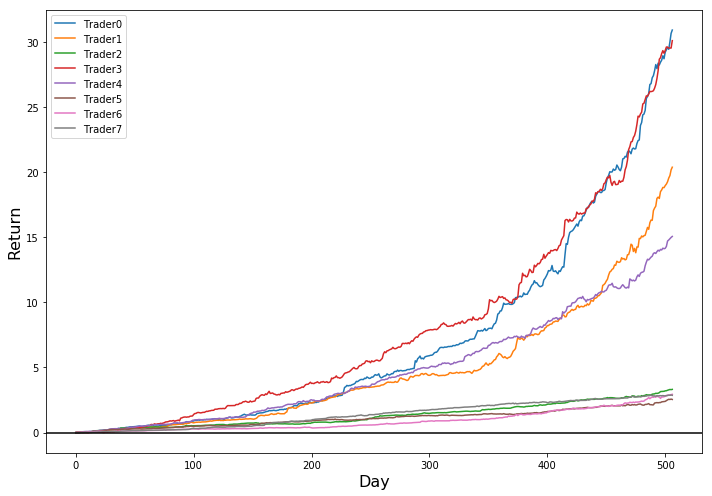

In [37]:
# Plot training results

plot_list = [[predictions_train_AAPL_MSFT, actuals_train_AAPL_MSFT],
             [predictions_train_SLB_HAL, actuals_train_SLB_HAL],
             [predictions_train_BAC_C, actuals_train_BAC_C],
             [predictions_train_AAL_UAL, actuals_train_AAL_UAL],
             [predictions_train_F_GM, actuals_train_F_GM],
             [predictions_train_GS_JPM, actuals_train_GS_JPM],
             [predictions_train_XOM_CVX, actuals_train_XOM_CVX],
             [predictions_train_KO_PEP, actuals_train_KO_PEP]
            ]

fig, ax = plt.subplots(figsize=(10,7))
train_results = pd.DataFrame()

for index, obj in enumerate(plot_list):
    predictions_train = obj[0]
    actuals_train = obj[1]

    init = 100
    position_train = []
    for i, val in enumerate(list(predictions_train)):
        if val >= 0:
            position_train.append(1)
        else:
            position_train.append(-1)
    train_result = np.array(position_train)*actuals_train
    train_results['Trader' + str(index)] = train_result
    cum_returns = np.cumprod(train_result+1)-1
    cum_returns = np.append([0], cum_returns)
    plt.plot(cum_returns, label=train_results.columns[index]);
        
ax.set_xlabel('Day', fontsize=16)
ax.set_ylabel('Return',fontsize=16)
plt.legend()
plt.tight_layout()
plt.axhline(y=0, color='black');
plt.savefig(fname='train_returns', dpi=150)
plt.show()

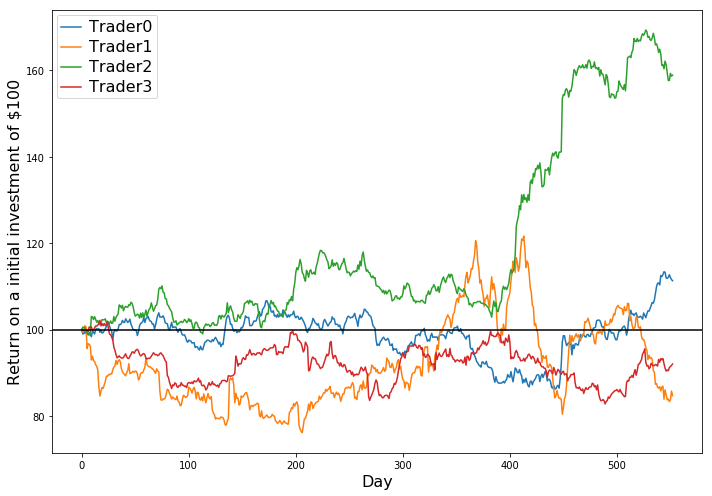

In [270]:
# Plot test results

plot_list = [#[predictions_test_AAPL_MSFT, actuals_test_AAPL_MSFT],
             #[predictions_test_SLB_HAL, actuals_test_SLB_HAL],
             [predictions_test_BAC_C, actuals_test_BAC_C],
             [predictions_test_AAL_UAL, actuals_test_AAL_UAL],
             #[predictions_test_F_GM, actuals_test_F_GM],
             [predictions_test_GS_JPM, actuals_test_GS_JPM],
             [predictions_test_XOM_CVX, actuals_test_XOM_CVX],
             #[predictions_test_KO_PEP, actuals_test_KO_PEP]
            ]

fig, ax = plt.subplots(figsize=(10,7))
test_results = pd.DataFrame()

for index, obj in enumerate(plot_list):
    predictions_test = obj[0]
    actuals_test = obj[1]

    init = 100
    position_test = []
    for i, val in enumerate(list(predictions_test)):
        if val >= 0:
            position_test.append(1)
        else:
            position_test.append(-1)
    test_result = np.array(position_test)*actuals_test
    test_results['Trader' + str(index)] = test_result
    cum_returns = np.cumprod(test_result[-p_and_l_mat.shape[0]:]+1)
    cum_returns = np.append([100], cum_returns*100)
    plt.plot(cum_returns, label=test_results.columns[index]);

ax.set_xlabel('Day', fontsize=16)
ax.set_ylabel('Return on a initial investment of $100',fontsize=16)
plt.legend()
plt.setp(ax.get_legend().get_texts(), fontsize=16)
plt.tight_layout()
plt.axhline(y=100, color='black');
plt.savefig(fname='test_returns', dpi=150)
plt.show()

In [222]:
my_dates[-cum_returns.shape[0]:].iloc[0]

Timestamp('2016-03-08 00:00:00')

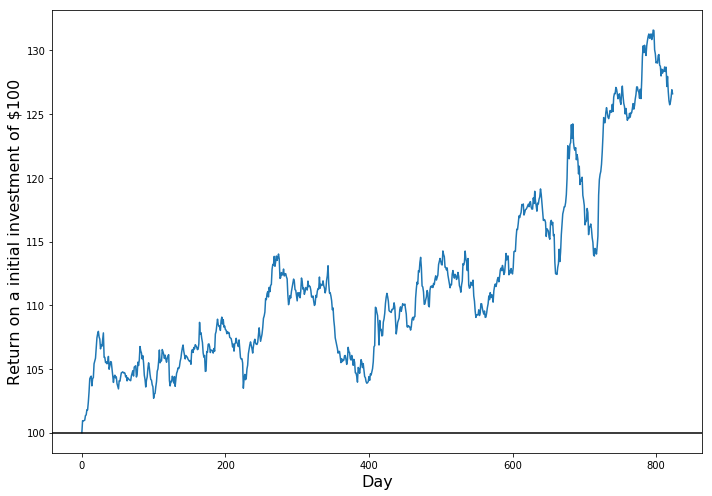

In [262]:
# Equal weight backtest for test period

fig, ax = plt.subplots(figsize=(10,7))
plt.plot(np.append(100, np.cumprod(1 + np.mean(test_results, axis=1))*100))
ax.set_xlabel('Day', fontsize=16)
ax.set_ylabel('Return on a initial investment of $100',fontsize=16)
plt.tight_layout()
plt.axhline(y=100, color='black');
plt.show()

In [233]:
train_results.corr()

,Trader0,Trader1,Trader2,Trader3,Trader4,Trader5,Trader6,Trader7
Trader0,1.000000,-0.034207,-0.024354,0.193321,0.021916,-0.068211,-0.037672,0.001778
Trader1,-0.034207,1.000000,-0.038570,-0.007780,0.025325,0.038862,0.001065,-0.036233
Trader2,-0.024354,-0.038570,1.000000,-0.100088,-0.042744,0.115699,0.008356,0.045001
Trader3,0.193321,-0.007780,-0.100088,1.000000,-0.053703,-0.028824,-0.005860,0.048713
Trader4,0.021916,0.025325,-0.042744,-0.053703,1.000000,0.058418,0.006673,0.024821
Trader5,-0.068211,0.038862,0.115699,-0.028824,0.058418,1.000000,0.056631,0.044947
Trader6,-0.037672,0.001065,0.008356,-0.005860,0.006673,0.056631,1.000000,0.035631
Trader7,0.001778,-0.036233,0.045001,0.048713,0.024821,0.044947,0.035631,1.000000


In [234]:
test_results.corr()

,Trader0,Trader1,Trader2,Trader3
Trader0,1.000000,-0.073038,0.082360,-0.023691
Trader1,-0.073038,1.000000,0.008982,-0.053294
Trader2,0.082360,0.008982,1.000000,0.019442
Trader3,-0.023691,-0.053294,0.019442,1.000000


In [235]:
# Summary Table of Test Results

port_results = np.mean(test_results, axis=1)
ret_port = (1 + np.mean(port_results))**252 - 1
risk_port = np.std(port_results)*(252**0.5)
sharpe_port = ret_port/risk_port

print('Return: ' + str(round(ret_port,3)))
print('Risk: ' + str(round(risk_port,3)))
print('Sharpe Ratio: ' + str(round(sharpe_port,3)))

Return: 0.078
Risk: 0.082
Sharpe Ratio: 0.962


In [236]:
# Create the manager using an XG Boosted Tree
import xgboost as xgb

xg_train_len = 180

In [237]:
def make_xg_tree(xg_tree_func, trader_results, lags_tree):
    xg_in_X, xg_in_Y, features_xgb = make_variables(np.matrix(trader_results).T, lags_tree, 0, 1)
    xg_in_X = xg_in_X.reshape((xg_in_X.shape[0], xg_in_X.shape[2]))
    xg_in_Y_class = []
    for i in xg_in_Y:
        if i > 0:
            xg_in_Y_class.append(1)
        else:
            xg_in_Y_class.append(0)

    xg_tree_func.fit(xg_in_X[:xg_train_len], xg_in_Y_class[:xg_train_len])

    xg_predictions_train = xg_tree_func.predict_proba(xg_in_X[:xg_train_len])
    xg_predictions_test = xg_tree_func.predict_proba(xg_in_X[xg_train_len:])
    
    return xg_tree_func, xg_predictions_test, xg_predictions_train, xg_in_X, xg_in_Y_class, xg_in_Y

In [244]:
lags_tree = 90

xg_tree0 = xgb.XGBClassifier(objective = 'binary:logistic', eval_metric = 'auc',
                             subsample = 0.7, colsample_bytree = 0.7,
                             learning_rate = 0.1, gamma = 0.2, max_depth = 7, 
                             alpha = 10, n_estimators = 3000)
xg_tree0, xg_predictions_test0, xg_predictions_train0, xg_in_X0, xg_in_Y_class0, xg_in_Y0 = make_xg_tree(xg_tree0, test_results['Trader0'], lags_tree)


xg_tree1 = xgb.XGBClassifier(objective = 'binary:logistic', eval_metric = 'auc',
                             subsample = 0.7, colsample_bytree = 0.7,
                             learning_rate = 0.2, gamma = 0.2, max_depth = 10, 
                             alpha = 10, n_estimators = 3000)
xg_tree1, xg_predictions_test1, xg_predictions_train1, xg_in_X1, xg_in_Y_class1, xg_in_Y1 = make_xg_tree(xg_tree1, test_results['Trader1'], lags_tree)


xg_tree2 = xgb.XGBClassifier(objective = 'binary:logistic', eval_metric = 'auc',
                             subsample = 0.7, colsample_bytree = 0.7,
                             learning_rate = 0.2, gamma = 0.2, max_depth = 10, 
                             alpha = 10, n_estimators = 3000)
xg_tree2, xg_predictions_test2, xg_predictions_train2, xg_in_X2, xg_in_Y_class2, xg_in_Y2 = make_xg_tree(xg_tree2, test_results['Trader2'], lags_tree)


xg_tree3 = xgb.XGBClassifier(objective = 'binary:logistic', eval_metric = 'auc',
                             subsample = 0.7, colsample_bytree = 0.7,
                             learning_rate = 0.2, gamma = 0.2, max_depth = 10, 
                             alpha = 10, n_estimators = 3000)
xg_tree3, xg_predictions_test3, xg_predictions_train3, xg_in_X3, xg_in_Y_class3, xg_in_Y3 = make_xg_tree(xg_tree3, test_results['Trader3'], lags_tree)


# xg_tree4 = xgb.XGBClassifier(objective = 'binary:logistic', eval_metric = 'auc',
#                              subsample = 0.7, colsample_bytree = 0.7,
#                              learning_rate = 0.2, gamma = 0.2, max_depth = 10, 
#                              alpha = 10, n_estimators = 1000)
# xg_tree4, xg_predictions_test4, xg_predictions_train4, xg_in_X4, xg_in_Y_class4, xg_in_Y4 = make_xg_tree(xg_tree4, test_results['Trader4'], lags_tree)


# xg_tree5 = xgb.XGBClassifier(objective = 'binary:logistic', eval_metric = 'auc',
#                              subsample = 0.7, colsample_bytree = 0.7,
#                              learning_rate = 0.2, gamma = 0.2, max_depth = 10, 
#                              alpha = 10, n_estimators = 1000)
# xg_tree5, xg_predictions_test5, xg_predictions_train5, xg_in_X5, xg_in_Y_class5, xg_in_Y5 = make_xg_tree(xg_tree5, test_results['Trader5'], lags_tree)

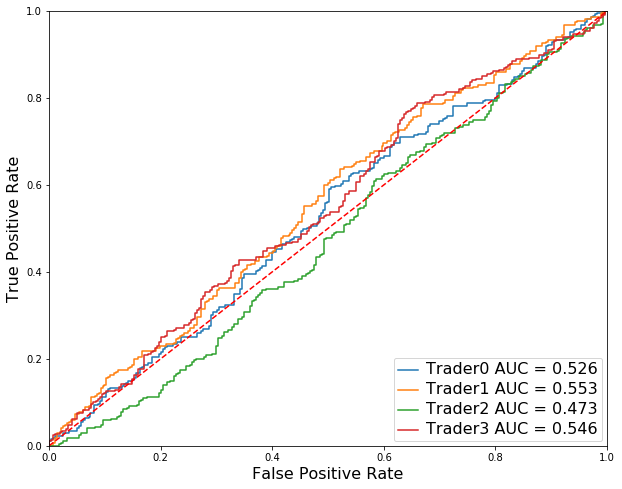

In [250]:
import sklearn.metrics as metrics

cutoff = 0.30

# model_list = [xg_tree0, xg_tree1, xg_tree2 ,xg_tree3 ,xg_tree4, xg_tree5]
# model_name = ['Trader0', 'Trader1', 'Trader2', 'Trader3', 'Trader4', 'Trader5']
# y_vals = [xg_in_Y_class0, xg_in_Y_class1, xg_in_Y_class2, xg_in_Y_class3, xg_in_Y_class4, xg_in_Y_class5]
# y_rets = [xg_in_Y0, xg_in_Y1, xg_in_Y2, xg_in_Y3, xg_in_Y4, xg_in_Y5]
# x_vals = [xg_in_X0, xg_in_X1, xg_in_X2, xg_in_X3, xg_in_X4, xg_in_X5]

model_list = [xg_tree0, xg_tree1, xg_tree2 ,xg_tree3]
model_name = ['Trader0', 'Trader1', 'Trader2', 'Trader3']
y_vals = [xg_in_Y_class0, xg_in_Y_class1, xg_in_Y_class2, xg_in_Y_class3]
y_rets = [xg_in_Y0, xg_in_Y1, xg_in_Y2, xg_in_Y3]
x_vals = [xg_in_X0, xg_in_X1, xg_in_X2, xg_in_X3]

# Plot ROC curve for all my models
fig, ax = plt.subplots(figsize=(10,8))
p_and_l = []

for i, model in enumerate(model_list):
    y_val = y_vals[i][xg_train_len:]
    y_ret = y_rets[i][xg_train_len:]
    y_pred = list(model.predict_proba(x_vals[i][xg_train_len:])[:,1])
    y_pred_class = []
    for p in y_pred:
        if p > cutoff:
            y_pred_class.append(1)
        else:
            y_pred_class.append(0)
    p_and_l.append(np.array(y_pred_class).reshape((-1,1))*np.array(y_ret).reshape((-1,1)))
    fpr, tpr, threshold = metrics.roc_curve(y_val, y_pred)
    roc_auc = metrics.auc(fpr, tpr)
    plt.plot(fpr, tpr, label = (model_name[i] + ' AUC = %0.3f' % roc_auc))

plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
ax.set_xlabel("False Positive Rate",fontsize=16)
ax.set_ylabel("True Positive Rate",fontsize=16)
plt.setp(ax.get_legend().get_texts(), fontsize=16)
plt.savefig(fname='PM_ROC_Curve', dpi=150)
plt.show()

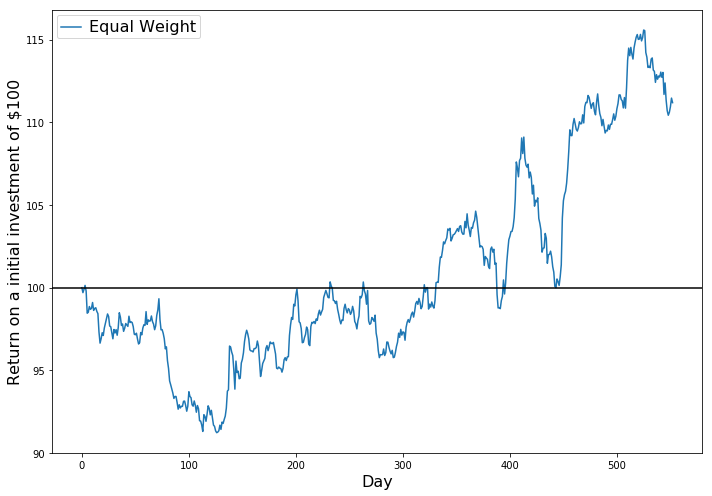

In [273]:
# Calculate backtest with risk managers

p_and_l_mat = p_and_l[0]
for i in p_and_l[1:]:
    p_and_l_mat = np.append(p_and_l_mat, i, axis=1)

# Equal weight backtest for test period
fig, ax = plt.subplots(figsize=(10,7))
plt.plot(np.append(100, np.cumprod(1 + np.mean(test_results[-p_and_l_mat.shape[0]:], axis=1))*100), label='Equal Weight')
ax.set_xlabel('Day', fontsize=16)
ax.set_ylabel('Return on a initial investment of $100',fontsize=16)
plt.legend()
plt.setp(ax.get_legend().get_texts(), fontsize=16)
plt.tight_layout()
plt.axhline(y=100, color='black');
plt.savefig(fname='test_port_returns', dpi=150)
plt.show()

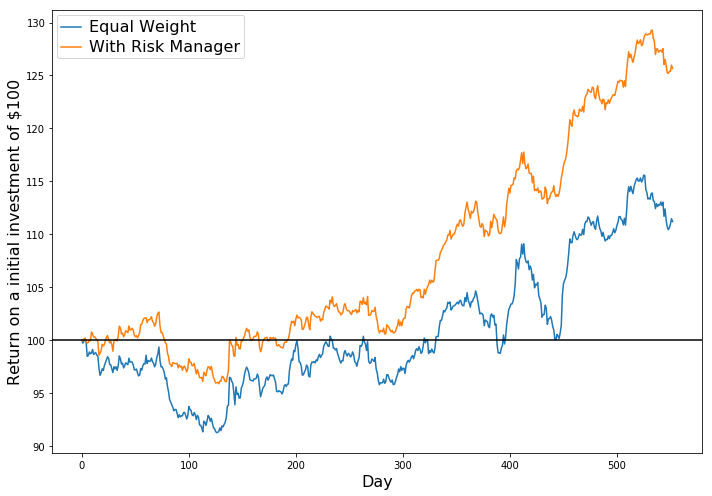

In [274]:
# Calculate backtest with risk managers

p_and_l_mat = p_and_l[0]
for i in p_and_l[1:]:
    p_and_l_mat = np.append(p_and_l_mat, i, axis=1)

# Equal weight backtest for test period
fig, ax = plt.subplots(figsize=(10,7))
plt.plot(np.append(100, np.cumprod(1 + np.mean(test_results[-p_and_l_mat.shape[0]:], axis=1))*100), label='Equal Weight')
plt.plot(np.append(100, np.cumprod(1 + np.mean(p_and_l_mat, axis=1))*100), label='With Risk Manager')
ax.set_xlabel('Day', fontsize=16)
ax.set_ylabel('Return on a initial investment of $100',fontsize=16)
plt.legend()
plt.setp(ax.get_legend().get_texts(), fontsize=16)
plt.tight_layout()
plt.axhline(y=100, color='black');
plt.savefig(fname='Final_Results', dpi=150)
plt.show()

In [261]:
# Summary Table of True Test Results

port_final_results = np.mean(p_and_l_mat, axis=1)
ret_port = (1 + np.mean(port_final_results))**252 - 1
risk_port = np.std(port_final_results)*(252**0.5)
sharpe_port = ret_port/risk_port

print('Return: ' + str(round(ret_port,3)))
print('Risk: ' + str(round(risk_port,3)))
print('Sharpe Ratio: ' + str(round(sharpe_port,3)))
print('\n')

port_final_results_raw = np.mean(test_results[-p_and_l_mat.shape[0]:], axis=1)
ret_port = (1 + np.mean(port_final_results_raw))**252 - 1
risk_port = np.std(port_final_results_raw)*(252**0.5)
sharpe_port = ret_port/risk_port

print('Return: ' + str(round(ret_port,3)))
print('Risk: ' + str(round(risk_port,3)))
print('Sharpe Ratio: ' + str(round(sharpe_port,3)))

Return: 0.113
Risk: 0.071
Sharpe Ratio: 1.593


Return: 0.053
Risk: 0.084
Sharpe Ratio: 0.633


In [256]:
# Pickle the results
import pickle

file = open('train_true_test', 'wb')
pickle.dump(train_results, file)
file.close()

file = open('test_true_test', 'wb')
pickle.dump(test_results, file)
file.close()